# Imports and Data Information

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.formula.api import logit
# Loading data, maths, etc.
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from scipy import stats
# Plotting results
import matplotlib.pyplot as plt
import seaborn as sns
import forestplot as fp
from statsmodels.graphics.factorplots import interaction_plot
# Analyzing regression results
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Dataset

In [ ]:
cmv = pd.read_csv("data/enriched_datasets/cmv_all_features.csv", sep="\t")

In [4]:
target_col = 'persuasiveness'

storytelling = ['storytelling_mixed_domain', 'storytelling_one_domain']
storytelling_probs = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']

hedging = ['first_abs_hedge', 'first_hedge', 'final_abs_hedge', 'final_hedge', 'global_abs_hedge', 'avg_hedge']

In [5]:
emotion_orig = [
    'anger_unmasked_agg', 'boredom_unmasked_agg', 
    'disgust_unmasked_agg', 'fear_unmasked_agg', 
    'guilt_shame_unmasked_agg', 'joy_unmasked_agg', 
    'pride_unmasked_agg', 'relief_unmasked_agg', 
    'sadness_unmasked_agg', #'surprise_unmasked_agg', 
    'trust_unmasked_agg', 
    # 'negative_unmasked_agg', 'positive_unmasked_agg'
]
emotion_probs_orig = [
    'prob_anger_unmasked_agg', 'prob_boredom_unmasked_agg', 'prob_disgust_unmasked_agg', 
    'prob_fear_unmasked_agg', 'prob_guilt_shame_unmasked_agg', 'prob_joy_unmasked_agg', 
    'prob_pride_unmasked_agg', 'prob_relief_unmasked_agg', 'prob_sadness_unmasked_agg', 
    'prob_surprise_unmasked_agg', 'prob_trust_unmasked_agg'
]

emotion_orig_progression = [
    'anger_unmasked_progress', 'boredom_unmasked_progress', 
    'disgust_unmasked_progress', 'fear_unmasked_progress', 
    'guilt_shame_unmasked_progress', 'joy_unmasked_progress', 
    'pride_unmasked_progress', 'relief_unmasked_progress', 
    'sadness_unmasked_progress', 'surprise_unmasked_progress', 
    'trust_unmasked_progress', 
    # 'negative_unmasked_progress', 'positive_unmasked_progress'
]
emotion_probs_orig_progression = [
    'prob_anger_unmasked_progress', 'prob_boredom_unmasked_progress', 'prob_disgust_unmasked_progress', 
    'prob_fear_unmasked_progress', 'prob_guilt_shame_unmasked_progress', 'prob_joy_unmasked_progress', 
    'prob_pride_unmasked_progress', 'prob_relief_unmasked_progress', 'prob_sadness_unmasked_progress', 
    'prob_surprise_unmasked_progress', 'prob_trust_unmasked_progress'
]

emotion_masked = [
    'anger_masked_agg', 'boredom_masked_agg', 'disgust_masked_agg', 
    'fear_masked_agg', 'guilt_shame_masked_agg', 'joy_masked_agg', 
    'pride_masked_agg', 'relief_masked_agg', 'sadness_masked_agg', 
    'surprise_masked_agg', 'trust_masked_agg', 
    # 'negative_masked_agg', 'positive_masked_agg'
]
emotion_probs_masked = [
    'prob_anger_masked_agg', 'prob_boredom_masked_agg', 
    'prob_disgust_masked_agg', 
    'prob_fear_masked_agg', 'prob_guilt_shame_masked_agg', 'prob_joy_masked_agg', 
    'prob_pride_masked_agg', 'prob_relief_masked_agg', 'prob_sadness_masked_agg', 
    #'prob_surprise_masked_agg', 
    'prob_trust_masked_agg'
    ]
emotion_masked_progression = [
    'anger_masked_progress', 'boredom_masked_progress', 'disgust_masked_progress', 
    'fear_masked_progress', 'guilt_shame_masked_progress', 'joy_masked_progress', 
    'pride_masked_progress', 'relief_masked_progress', 'sadness_masked_progress', 
    'surprise_masked_progress', 'trust_masked_progress', 
    # 'negative_masked_progress', 'positive_masked_progress'
]
emotion_probs_masked_progression = [
    'prob_anger_masked_progress', 'prob_boredom_masked_progress', 'prob_disgust_masked_progress', 
    'prob_fear_masked_progress', 'prob_guilt_shame_masked_progress', 'prob_joy_masked_progress', 
    'prob_pride_masked_progress', 'prob_relief_masked_progress', 'prob_sadness_masked_progress', 
    'prob_surprise_masked_progress', 'prob_trust_masked_progress'
    ]

emotion_probs_masked_whole = [
    'prob_anger_masked', 'prob_boredom_masked', 
    'prob_disgust_masked', 'prob_fear_masked', 
    'prob_guilt_shame_masked', 'prob_joy_masked', 
    'prob_pride_masked', 'prob_relief_masked', 
    'prob_sadness_masked', 'prob_surprise_masked', 
    'prob_trust_masked'
    ]
emotion_probs_orig_whole = [
    'prob_anger_unmasked', 'prob_boredom_unmasked', 
    'prob_disgust_unmasked', 'prob_fear_unmasked', 
    'prob_guilt_shame_unmasked', 'prob_joy_unmasked', 
    'prob_pride_unmasked', 'prob_relief_unmasked', 
    'prob_sadness_unmasked', 'prob_surprise_unmasked', 
    'prob_trust_unmasked'
]

emotion_masked_whole = [
    'anger_masked', 'boredom_masked', 
    'disgust_masked', 'fear_masked', 
    'guilt_shame_masked', 'joy_masked', 
    'pride_masked', 'relief_masked', 
    'sadness_masked', 'surprise_masked', 
    'trust_masked'
    ]
emotion_orig_whole = [
    'anger_unmasked', 'boredom_unmasked', 
    'disgust_unmasked', 'fear_unmasked', 
    'guilt_shame_unmasked', 'joy_unmasked', 
    'pride_unmasked', 'relief_unmasked', 
    'sadness_unmasked', 'surprise_unmasked', 
    'trust_unmasked'
]

# emotion_end_masked = [
#     'prob_anger_masked_end', 'prob_boredom_masked_end', 
#     'prob_disgust_masked_end', 'prob_fear_masked_end', 
#     'prob_guilt_shame_masked_end', 'ürob_joy_masked_end', 
#     'prob_pride_masked_end', 'prob_relief_masked_end', 
#     'prob_sadness_masked_end', 'prob_surprise_masked_end', 
#     'prob_trust_masked_end'
#     ]
# emotion_end_orig = [
#     'prob_anger_unmasked_end', 'prob_boredom_unmasked_end', 
#     'prob_disgust_unmasked_end', 'prob_fear_unmasked_end', 
#     'prob_guilt_shame_unmasked_end', 'joy_unmasked_end', 
#     'prob_pride_unmasked_end', 'prob_relief_unmasked_end', 
#     'prob_sadness_unmasked_end', 'prob_surprise_unmasked_end', 
#     'prob_trust_unmasked_end'
# ]

Apart from the classification results for emotion and storytelling and the hedging counts, the table includes the following accumulated hyperclasses and modified features:
- `negative_[un]masked`: Binary feature denoting the presence of negative emotions aggregated from the classification results of anger, boredom, disgust, fear, guilt/shame and sadness of the corresponding classifier (`masked`, `unmasked`)
- `positive_[un]masked`: Corresponding feature for the positive emotions joy, pride, relief, surprise, trust
- `emotionality_[un]masked`: Aggregated count of the classification results of all emotions for one training variant (`masked`, `unmasked`), the feature can adapt values [0;11] depending on how many of the eleven emotions were predicted for the instance
- `log_rank`: The argument quality label `rank` transformed into log space
- `prob_[emotion]_[un]masked`, `prob_storytelling[one/mixed]_domain`: The average of the raw probability output of the 10 ensembled classifiers for each feature/variant combination

This results in the following features:

| **List** | **Features**|
|---|---|
| - | text_id |
| `target_cols` | rank, log_rank |
| `neg_masked` | anger_masked, boredom_masked, disgust_masked, fear_masked, guilt_shame_masked, sadness_masked |
| `neg_unmasked` | anger_unmasked, boredom_unmasked, disgust_unmasked, fear_unmasked, guilt_shame_unmasked, sadness_unmasked |
| `pos_masked` | joy_masked, pride_masked, relief_masked, surprise_masked, trust_masked |
| `pos_unmasked` | joy_unmasked, pride_unmasked, relief_unmasked, surprise_unmasked, trust_unmasked |
| `prob_emo_masked` | prob_anger_masked, prob_boredom_masked, prob_disgust_masked, prob_fear_masked, prob_guilt_shame_masked, prob_joy_masked, prob_pride_masked, prob_relief_masked, prob_sadness_masked, prob_surprise_masked, prob_trust_masked |
| `prob_emo_unmasked` | prob_anger_unmasked, prob_boredom_unmasked, prob_disgust_unmasked, prob_fear_unmasked, prob_guilt_shame_unmasked, prob_joy_unmasked, prob_pride_unmasked, prob_relief_unmasked, prob_sadness_unmasked, prob_surprise_unmasked, prob_trust_unmasked |
| `hedging` | avg_hedge, final_abs_hedge, final_hedge, first_abs_hedge, first_hedge, global_abs_hedge |
| - | negative_masked, positive_masked, negative_unmasked, positive_unmasked |
| `story` | storytelling_one_domain, storytelling_mixed_domain |
| `prob_story` | prob_storytelling_mixed_domain, prob_storytelling_one_domain |

In [10]:
# prob_emo_masked = ['prob_anger_masked', 'prob_boredom_masked', 'prob_disgust_masked', 'prob_fear_masked', 'prob_guilt_shame_masked', 'prob_joy_masked', 'prob_pride_masked', 'prob_relief_masked', 'prob_sadness_masked', 'prob_surprise_masked', 'prob_trust_masked']
# prob_emo_unmasked = ['prob_anger_unmasked', 'prob_boredom_unmasked', 'prob_disgust_unmasked', 'prob_fear_unmasked', 'prob_guilt_shame_unmasked', 'prob_joy_unmasked', 'prob_pride_unmasked', 'prob_relief_unmasked', 'prob_sadness_unmasked', 'prob_surprise_unmasked', 'prob_trust_unmasked']
# prob_story = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']


In [6]:
y = cmv.loc[:, "persuasiveness"]

### Data distribution

In [8]:
dist_cols = emotion_probs + storytelling_probs
l = len(cmv)
print("Overall number of instances:", l)
m = len(max(dist_cols, key=lambda x:len(x)))
x = f"{'Feature': <31} - {'#': ^4} / ratio\t\t{'Feature': <31} - {'#': ^4} / ratio\n{'_'*46}\t\t{'_'*46}\n"
for i, co in enumerate(dist_cols):
    x += f"{co: <31} - {int(round(cmv[co].sum(),0)): >4} / {round(cmv[co].sum()/l, 3): <5}"
    if i%2:
        x +="\n"
    else: x +="\t\t"
print(x)

NameError: name 'emotion_probs' is not defined

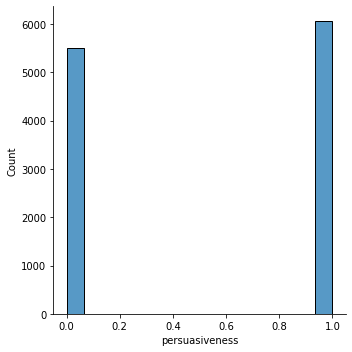

In [9]:
sns.displot(cmv, x="persuasiveness")

# Linear Regression
Each of the following models will have just one independent variable, sorted by variable type: 
1. emotion
    - masked
    - unmasked
2. storytelling
    - mixed domain
    - one domain
3. hedging
4. all 3 features

In sections (1) and (2), the LR uses the discreet/binary values from the classifier and not the probability outputs and section (4) consists of a model that includes independent variables from all three features, choosing the feature variant that is most informative for the regression (highest R<sup>2</sup>).

**ATTENTION** - p-value significance levels are 0.05 (*), 0.01 (\*\*), 0.001 (\*\*\*)

## 0. Functions for step-wise regression

In [7]:
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, 
    return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    print("params_big:", big_model.df_model, "params_small:", small_model.df_model, "scale_big:", big_model.scale)
    f_stat = (sum(small_model.resid_dev**2) - sum(big_model.resid_dev**2)) / (addtl_params * big_model.scale) # resid_dev statt deviance?
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [8]:
# Forward selection function for linear models
def forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    r_vals = []
    sign = []
    current_score, best_new_score = float('0'), float('0')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                        ' + '.join(selected + [candidate]))
            score = logit(formula, data).fit().prsquared
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score < best_new_score:
            if len(selected):
                old_model = current_model
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_model = logit(f"{response} ~ {' + '.join(selected)}", data).fit()
            r_vals.append(current_model.prsquared)
            if len(sign):
                table = calculate_nested_f_statistic(old_model, current_model)
                sign.append(table[1])
            else:
                sign.append("x")
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = logit(formula, data).fit()
    return {"model": model, "remaining": remaining, "r2": r_vals, "significance":  sign}

In [9]:
# Forward selection function for linear models
def poly_forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    interactions = set()
    for i in remaining:
        for j in remaining:
            if i != j and j+":"+i not in remaining:
                interactions.add(i+":"+j)
    remaining.update(interactions)
    selected = []
    r_vals = []
    sign = []
    current_score, best_new_score = float('inf'), float('inf')  # float('0'), float('0')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            print(candidate)
            formula = "{} ~ {}".format(response,
                                        ' + '.join(selected + [candidate]))
            score = logit(formula, data).fit().aic #prsquared  # aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()#reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score > best_new_score:
            if len(selected):
                old_model = current_model
                current_model = logit(f"{response} ~ {' + '.join(selected + [best_candidate])}", data).fit()
                table = calculate_nested_f_statistic(old_model, current_model)
                sign.append(table[1])
                r_vals.append(current_model.prsquared)
                if sign[-1] < 0.05:
                    remaining.remove(best_candidate)
                    selected.append(best_candidate)
                    current_score = best_new_score
            else:
                current_model = logit(f"{response} ~ {best_candidate}", data).fit()
                sign.append("x")
                r_vals.append(current_model.prsquared)
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = logit(formula, data).fit()
    return {"model": model, "remaining": remaining, "r2": r_vals, "significance":  sign}

In [10]:
def feature(x):
    #"emotion", "train", "anno", "split"
    feat = ""
    if x[2] == "prob":
        feat += "prob_"
    feat += x[0] + "_" + x[1] 
    if x[3] == "agg":
        feat += "_" + x[3]
    return feat

# def re_feats(x):
#     out = ""
#     if ":" in x:
#         x1, x2 = x.split(":")
#         out = re_feats(x1) + " : " + re_feats(x2)
#         return out
#     x = x.split("_")
#     if x[0] == "prob":
#         out += ", p)"
#         x.pop(0)
#     else:
#         out += ", d)"
#     if x[-1] == "agg":
#         out = ", agg" + out
#         x.pop(-1)
#     elif x[-1] == "progress":
#         out = ", prog" + out
#         x.pop(-1)
#     if x[-1] == "masked":
#         out = " (m" + out
#         x.pop(-1)
#     else:
#         out = " (o" + out
#         x.pop(-1)
#     if len(x)>1:
#         out = "/shame" + out
#     out = x[0].title() + out
#     return out

def re_feats(x):
    out = ""
    if ":" in x:
        x1, x2 = x.split(":")
        out = re_feats(x1) + " : " + re_feats(x2)
        return out
    x = x.split("_")
    if "guilt" in x:
        return "guilt/shame"
    elif "storytelling" in x:
        return "storytelling"
    elif "hedge" in x:
        if "avg" in x:
            return "avg(all hedge)"
        elif "abs" not in x:
            return f"avg({x[0]} hedge)"
        elif "global" in x:
            return "all hedge"
        else:
            return x[0] + " hedge"
    else:
        if x[0] == "prob":
            return x[1]
        else: return x[0]

# 1. Emotions
The possible variants here are the features predicted by the classifier using data with masked emotion words or unmasked texts:

## 1.1 Simple regression

In [11]:
emo_vars = emotion_orig_whole+emotion_masked_whole+emotion_orig+emotion_masked+emotion_orig_progression+emotion_masked_progression+emotion_probs_orig+emotion_probs_masked+emotion_probs_orig_progression+emotion_probs_masked_progression
x = [", ".join(emo_vars[i-6:i]) for i in range(6,120,6)]
x = "\n".join(x)
print(x)

anger_unmasked, boredom_unmasked, disgust_unmasked, fear_unmasked, guilt_shame_unmasked, joy_unmasked
pride_unmasked, relief_unmasked, sadness_unmasked, surprise_unmasked, trust_unmasked, anger_masked
boredom_masked, disgust_masked, fear_masked, guilt_shame_masked, joy_masked, pride_masked
relief_masked, sadness_masked, surprise_masked, trust_masked, anger_unmasked_agg, boredom_unmasked_agg
disgust_unmasked_agg, fear_unmasked_agg, guilt_shame_unmasked_agg, joy_unmasked_agg, pride_unmasked_agg, relief_unmasked_agg
sadness_unmasked_agg, trust_unmasked_agg, anger_masked_agg, boredom_masked_agg, disgust_masked_agg, fear_masked_agg
guilt_shame_masked_agg, joy_masked_agg, pride_masked_agg, relief_masked_agg, sadness_masked_agg, surprise_masked_agg
trust_masked_agg, anger_unmasked_progress, boredom_unmasked_progress, disgust_unmasked_progress, fear_unmasked_progress, guilt_shame_unmasked_progress
joy_unmasked_progress, pride_unmasked_progress, relief_unmasked_progress, sadness_unmasked_progre

In [22]:
simple_results = {emo[:-13]: {} for emo in emotion_orig}
for k in simple_results:
    simple_results[k] = {
        "unmasked": {
            "progress": {"discrete":{}, "prob": {}}, 
            "agg": {"discrete":{}, "prob": {}}, 
            "whole": {"discrete":{}, "prob": {}}}, 
        "masked": {
            "progress": {"discrete":{}, "prob": {}}, 
            "agg": {"discrete":{}, "prob": {}}, 
            "whole": {"discrete":{}, "prob": {}}}}
masked_results = {emo[:-13]:{} for emo in emotion_orig} 

for v in emo_vars:#emotion_probs_masked:#emo_vars:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    results = logit(formula, cmv).fit()
    var_labels = v.split("_")
    if "unmasked" in var_labels:
        train = "unmasked"
    else:
        train = "masked"
    if "agg" in var_labels:
        split = "agg"
    elif "progression" in var_labels:
        split = "progress"
    else:
        split = "whole"
    if "prob" in var_labels:
        anno = "prob"
        emo = var_labels[1]
        if emo == "guilt":
            emo += "_shame"
    else:
        anno = "discrete"
        emo = var_labels[0]
        if emo == "guilt":
            emo += "_shame"
    simple_results[emo][train][split][anno] = {"r2": results.prsquared, "odds": np.exp(results.params[v]), "p": results.pvalues[v]}
    emo = v[5:-11]
    masked_results[emo] = {"r2": results.prsquared, "p": results.pvalues[v], "odds": np.exp(results.params[v])}
    print(results.summary())

masked_results = pd.DataFrame(masked_results).transpose()
print(masked_results.to_latex(float_format="%.4f"))

IV: anger_unmasked
Optimization terminated successfully.
         Current function value: 0.691868
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               0.0001725
Time:                        11:49:16   Log-Likelihood:                -8002.8
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                   0.09659
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1257      0.026      4.899      0.000       0.075       0.17

The results show that many of the features have no measurable effect on argument strength, as they cannot explain the variance in the data (R<sup>2</sup>=0), these features include _anger_, _boredom_, _fear_, _pride_, _relief_, _sadness_, _surprise_, and _emotionality_. Features that do explain part of the variance also have very small R<sup>2</sup> values, these include _trust_ (0.003, adjusted 0.002), negative _sentiment_ (0.002), _disgust_ (0.001), _guilt/shame_ (0.001), positive _sentiment_ (0.001), and _joy_ (0.001, though no effect after adjusting R<sup>2</sup>).

_Trust_ and _negative sentiment_ thus explain the most variance in the data, with trust having a positive highly significant (p=.001) and negative sentiment a negative significant (p=.002) effect. We can thus extrapolate that negativity lowers the argument quality while displaying trust leads to higher argument quality. Both coefficients are very small, which is partly due to the interplay of the binary IV and very small DV, as the coefficient of each independent variable is only ever turned on or off (1/0 feature manifestation) but influences a dependent variable that is always between 0 and 1. Given this problem, the high significance of the effects weighs more than the low effect size.

Interesting however is that the most frequent emotion _disgust_ only explains .1% of variance and like the second most frequent emotion _anger_ has no significant influence on argument quality. This may be due to low classification performance, as the in-domain evaluation for _anger_ showed f<sub>1</sub> scores between .6 and .7 for the positive class with low precision. Such in-domain results indicate that the cross-domain deployment on the argument data might lead to overprediction of the emotion and might thus hinder finding meaningful patterns in the data.

### 1.1.1 Feature selection

This model uses all unmasked emotion features in a multilinear regression without interaction. 

In [12]:
best = []
split_comp = {"feature": [], "whole_r2": [], "agg_r2": [], "whole_p": [], "agg_p": []}
for emo in simple_results:
    cmv_best = []
    for train in simple_results[emo]:
        for split in {"whole", "agg"}:
            for anno in simple_results[emo][train][split]:
                cmv_best.append((emo, train, anno, split, simple_results[emo][train][split][anno]["odds"], simple_results[emo][train][split][anno]["p"], simple_results[emo][train][split][anno]["r2"]))
                if split == "whole":
                    split_comp["feature"].append("_".join((emo,train,anno)))
                split_comp[split+"_r2"].append(simple_results[emo][train][split][anno]["r2"])
                split_comp[split+"_p"].append(simple_results[emo][train][split][anno]["p"])
    cmv_best.sort(key= lambda x: x[-1], reverse=True)
    if cmv_best[0][-1] == 0:
        cmv_best.sort(key= lambda x: x[-2])
    best.append(cmv_best[0])

vars = {"unmasked": 0, "masked": 0, "discrete": 0, "prob": 0, "agg": 0, "whole": 0}
for i in best:
    vars[i[1]] += 1
    vars[i[2]] += 1
    vars[i[3]] += 1
best = sorted(best, key=lambda x: x[-1], reverse=True)

# for i in best:
#     print(i)
print(vars)

split_comp = pd.DataFrame(split_comp)
x = []
for i, row in split_comp.iterrows():
    if row["whole_r2"] > row["agg_r2"]:
        x.append(row.feature)
print(x)
# split_comp
a = pd.DataFrame(best,columns=["emotion", "train", "anno", "split", "odds", "p", "r2"])
a

NameError: name 'simple_results' is not defined

In [24]:
a = (simple_results["boredom"]["unmasked"]["agg"], simple_results["boredom"]["masked"]["agg"])
a
# anger: exchange discrete for prob (no big r2 difference, but one step down in significance ** vs *)
# sadness: exchange discrete for prob (worse r2 and p, but both not significant by a long shot)
# boredom: no idea, much much worse p, but no significant effect either way



({'discrete': {'r2': np.float64(0.00011410054651961321),
   'odds': np.float64(0.8860483605658517),
   'p': np.float64(0.17649525180529935)},
  'prob': {'r2': np.float64(3.992078536163568e-05),
   'odds': np.float64(0.8798847290315187),
   'p': np.float64(0.4239704259334375)}},
 {'discrete': {'r2': np.float64(0.000109039076776285),
   'odds': np.float64(0.889861154004121),
   'p': np.float64(0.18638838265796875)},
  'prob': {'r2': np.float64(3.0164686577682787e-05),
   'odds': np.float64(0.89741395848077),
   'p': np.float64(0.4870410551465467)}})

**Binary emotion results** -- **Masked Emotion**

The results show that many of the features have no measurable effect on argument strength, as they cannot explain the variance in the data (R<sup>2</sup>=0), these features include _anger_, _boredom_, _fear_, _pride_, _relief_, _sadness_, _surprise_, and _emotionality_. Features that do explain part of the variance also have very small R<sup>2</sup> values, these include _trust_ (0.003, adjusted 0.002), negative _sentiment_ (0.002), _disgust_ (0.001), _guilt/shame_ (0.001), positive _sentiment_ (0.001), and _joy_ (0.001, though no effect after adjusting R<sup>2</sup>).

_Trust_ and _negative sentiment_ thus explain the most variance in the data, with trust having a positive highly significant (p=.001) and negative sentiment a negative significant (p=.002) effect. We can thus extrapolate that negativity lowers the argument quality while displaying trust leads to higher argument quality. Both coefficients are very small, which is partly due to the interplay of the binary IV and very small DV, as the coefficient of each independent variable is only ever turned on or off (1/0 feature manifestation) but influences a dependent variable that is always between 0 and 1. Given this problem, the high significance of the effects weighs more than the low effect size.

Interesting however is that the most frequent emotion _disgust_ only explains .1% of variance and like the second most frequent emotion _anger_ has no significant influence on argument quality. This may be due to low classification performance, as the in-domain evaluation for _anger_ showed f<sub>1</sub> scores between .6 and .7 for the positive class with low precision. Such in-domain results indicate that the cross-domain deployment on the argument data might lead to overprediction of the emotion and might thus hinder finding meaningful patterns in the data.

**Binary emotion results** -- **Unmasked Emotion**

Of all 14 masked emotion features, only 7 have non-nil R<sup>2</sup> values, those are in order of most explained variance: _trust_ (0.004), _relief_ (0.003), positive _sentiment_ (0.002), _pride_ (0.002, adjusted 0.001), negative _sentiment_ (0.002, adjusted 0.001), _disgust_ (0.001) and _guilt/shame_ (0.001). These are however more than in the unmasked feature variant, where after adjusting the R<sup>2</sup> only 5 features measurably explain some of the argument quality variance. The emotion features that do not explain any variance are _anger_, _boredom_, _fear_, _sadness_, _joy_, _surprise_, and _emotionality_. This is in line with the unmasked results, though the explanatory masked features generally explain more variance than their unmasked counterparts and include more effects of (high) significance.

Especially interesting is the positive effect of _positive sentiment_, which is significant (p=0.003, \*\*) unlike the masked significant effect (p=0.024, \*). The same but inverted observation holds for the _negative sentiment_, which has a negative effect for both masked and unmasked features, but is highly significant for the masked (p=0.002, \*\*) and significant (p=0.012, \*) for unmasked emotions.

**Binary emotion results** -- **Emotion Probabilities**




### 1.1.2 Emotion progression

In [14]:
progression_vars = sorted(emotion_masked_progression+emotion_probs_masked_progression, key=re_feats)
progression_results = {re_feats(emo): {} for emo in emotion_masked_whole}
for k in progression_results:
    progression_results[k] = {"discrete_r2":{}, "discrete_odds":{}, "discrete_p":{}, "prob_r2": {}, "prob_odds": {}, "prob_p": {}}

for v in progression_vars:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    results = logit(formula, cmv).fit()
    print(results.summary())

    emo = re_feats(v)
    if "prob_" in v:
        anno = "prob"
    else:
        anno = "discrete"
    print(anno)    
    progression_results[emo][anno+"_r2"] = results.prsquared
    progression_results[emo][anno+"_odds"] = np.exp(results.params[v])
    progression_results[emo][anno+"_p"] =  results.pvalues[v]
progression_results=pd.DataFrame(progression_results).transpose()
print(progression_results.to_latex(float_format="%.4f"))

IV: anger_masked_progress
Optimization terminated successfully.
         Current function value: 0.691987
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:               1.012e-06
Time:                        15:52:24   Log-Likelihood:                -8004.2
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                    0.8987
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0964      0.019      5.177      

In [186]:
progression_results.transpose()

,discrete_r2,discrete_odds,discrete_p,prob_r2,prob_odds,prob_p
anger_masked,0.000001,1.004257,0.89873,0.000034,1.056314,0.458975
anger_unmasked,0.000009,0.987358,0.69709,0.000005,1.017967,0.777969
boredom_masked,0.000004,1.02233,0.811626,0.000112,1.179206,0.181499
boredom_unmasked,0.000075,1.10924,0.272656,0.000081,1.166531,0.254403
disgust_masked,0.000002,0.993989,0.875124,0.0,0.997034,0.968396
disgust_unmasked,0.000002,0.992963,0.850654,0.00003,1.056658,0.489075
fear_masked,0.000027,1.05331,0.51183,0.000004,0.970127,0.794091
fear_unmasked,0.00028,1.330113,0.035136,0.000025,1.113698,0.526082
guilt_shame_masked,0.00005,0.927807,0.372992,0.000005,0.964106,0.767829
guilt_shame_unmasked,0.00006,1.098712,0.325887,0.000002,0.977505,0.8506


### 1.1.2 Emotion aggregated results

In [13]:
agg_vars = sorted(emotion_orig+emotion_probs_orig+emotion_masked+emotion_probs_masked)
agg_results = {emo: {} for emo in sorted(emotion_masked_whole+emotion_orig_whole)}
for k in agg_results:
    agg_results[k] = {"disc_r2":{}, "disc_odds":{}, "disc_p":{}, "prob_r2": {}, "prob_odds": {}, "prob_p": {}}

for v in agg_vars:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    results = logit(formula, cmv).fit()
    var_labels = v.split("_")
    if "unmasked" in var_labels:
        train = "unmasked"
    else:
        train = "masked"
    if "prob" in var_labels:
        print("probability")
        anno = "prob"
        emo = var_labels[1]
        if emo == "guilt":
            emo += "_shame"
    else:
        anno = "disc"
        emo = var_labels[0]
        if emo == "guilt":
            emo += "_shame"
    print(anno)    
    agg_results[emo+"_"+train][anno+"_r2"] = results.prsquared
    agg_results[emo+"_"+train][anno+"_odds"] = np.exp(results.params[v])
    agg_results[emo+"_"+train][anno+"_p"] =  results.pvalues[v]
    print(results.summary())
agg_results=pd.DataFrame(agg_results).transpose()
agg_results

agg_better_disc = agg_results.loc[agg_results['disc_r2']>agg_results['prob_r2']]

IV: anger_masked_agg
Optimization terminated successfully.
         Current function value: 0.691942
         Iterations 3
disc
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:               6.502e-05
Time:                        10:18:52   Log-Likelihood:                -8003.7
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                    0.3076
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1178      0.028      4.198      0.000       0.0

TypeError: '>' not supported between instances of 'float' and 'dict'

### 1.1.3 Emotion whole instance results

In [237]:
whole_vars = sorted(emotion_orig_whole+emotion_probs_orig_whole+emotion_masked_whole+emotion_probs_masked_whole)
whole_results = {emo: {} for emo in sorted(emotion_masked_whole+emotion_orig_whole)}
agg_masked = {emo[:-7]: {} for emo in emotion_masked_whole}
for k in whole_results:
    whole_results[k] = {"disc_r2":{}, "disc_odds":{}, "disc_p":{}, "prob_r2": {}, "prob_odds": {}, "prob_p": {}}

for v in whole_vars:
    formula = f"persuasiveness ~ {v}"

    # print("==============================================================================", "\n", "IV: ", v, sep="")
    results = logit(formula, cmv).fit()
    var_labels = v.split("_")
    if "unmasked" in var_labels:
        train = "unmasked"
    else:
        train = "masked"
    if "prob" in var_labels:
        print("probability")
        anno = "prob"
        emo = var_labels[1]
        if emo == "guilt":
            emo += "_shame"
    else:
        anno = "disc"
        emo = var_labels[0]
        if emo == "guilt":
            emo += "_shame"  
    whole_results[emo+"_"+train][anno+"_r2"] = results.prsquared
    whole_results[emo+"_"+train][anno+"_odds"] = np.exp(results.params[v])
    whole_results[emo+"_"+train][anno+"_p"] =  results.pvalues[v]
    # print(results.summary())
    if train == "masked" and anno == "prob":
        agg_masked[emo] = {"\\textbf{pseudo-\\textit{r}\\textsuperscript{2}}": results.prsquared, "\\textbf{p-Value}": results.pvalues[v], "\\textbf{Odds}": np.exp(results.params[v])}
whole_results=pd.DataFrame(whole_results).transpose()

agg_masked = pd.DataFrame(agg_masked).transpose()
print(agg_masked.to_latex(float_format="%.4f"))

whole_better_disc = whole_results.loc[whole_results["disc_r2"]>whole_results["prob_r2"]]

Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691868
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691972
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691910
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691467
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691395
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691933
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691762
  

In [238]:
x = agg_results.rename(columns={col: col+"_agg" for col in agg_results})
all_emo_res = pd.concat((x, whole_results),axis=1)
all_emo_res.sort_index(inplace=True)
x = [x for x in all_emo_res.columns if "odds" not in x]
all_emo_res = all_emo_res[x]

whole_better_disc

,disc_r2,disc_odds,disc_p,prob_r2,prob_odds,prob_p
boredom_masked,0.000022,0.906965,0.552452,0.000001,1.024369,0.894130
boredom_unmasked,0.000112,0.799726,0.182028,0.000041,1.154241,0.420082
fear_unmasked,0.000078,0.854310,0.262970,0.000018,0.913493,0.588974
joy_unmasked,0.000224,0.619712,0.060790,0.000005,1.080197,0.776439
sadness_unmasked,0.000065,1.227073,0.311300,0.000005,1.061464,0.784611
trust_unmasked,0.000010,1.180939,0.692841,0.000003,1.093915,0.836101


In [240]:
print("Aggregated annotation")
agg_better_disc

Aggregated annotation


,disc_r2,disc_odds,disc_p,prob_r2,prob_odds,prob_p
anger_masked,0.000065,0.962462,0.307643,4.871222e-05,0.927995,0.377212
anger_unmasked,0.000415,0.908494,0.009988,4.125347e-04,0.818032,0.010191
boredom_masked,0.000109,0.889861,0.186388,3.016469e-05,0.897414,0.487041
boredom_unmasked,0.000114,0.886048,0.176495,3.992079e-05,0.879885,0.423970
disgust_unmasked,0.000855,0.870220,0.000217,7.085186e-04,0.767566,0.000761
fear_unmasked,0.000104,0.850799,0.197977,3.885694e-05,0.845226,0.430225
joy_unmasked,0.000015,1.081099,0.623470,9.538207e-06,1.106599,0.696096
pride_unmasked,0.000128,0.916424,0.151424,2.779485e-08,0.997513,0.983174
sadness_masked,0.000047,0.917984,0.384530,3.262858e-05,1.138134,0.470023
sadness_unmasked,0.000007,1.034019,0.746207,1.901740e-06,1.031406,0.861500


In [215]:
print("Normal annotation")
whole_results

Normal annotation


,disc_r2,disc_odds,disc_p,prob_r2,prob_odds,prob_p
anger_masked,8.835142e-05,0.956616,0.234338,0.000180,0.865008,8.939831e-02
anger_unmasked,1.724721e-04,0.939915,0.096599,0.000306,0.850314,2.689151e-02
boredom_masked,2.203895e-05,0.906965,0.552452,0.000001,1.024369,8.941302e-01
boredom_unmasked,1.115327e-04,0.799726,0.182028,0.000041,1.154241,4.200819e-01
disgust_masked,7.518275e-04,0.860574,0.000522,0.000914,0.718313,1.315870e-04
disgust_unmasked,8.560150e-04,0.843577,0.000214,0.001392,0.703510,2.398158e-06
fear_masked,1.263976e-05,1.059467,0.653044,0.000079,1.193004,2.598654e-01
fear_unmasked,7.831338e-05,0.854310,0.262970,0.000018,0.913493,5.889736e-01
guilt_shame_masked,3.386300e-04,0.754548,0.020201,0.001247,0.519810,8.301341e-06
guilt_shame_unmasked,3.259166e-04,0.695029,0.023051,0.001709,0.404558,2.073423e-07


## 1.2 Multilinear regression

The following model uses all unmasked emotion features as above, but includes pairwise interaction between the variables. 

In [25]:
# emo_cols = [feature(x) for x in best] + ["persuasiveness"]
emo_cols = emotion_probs_masked + ["persuasiveness"]
emo_cols


['prob_anger_masked_agg',
 'prob_boredom_masked_agg',
 'prob_disgust_masked_agg',
 'prob_fear_masked_agg',
 'prob_guilt_shame_masked_agg',
 'prob_joy_masked_agg',
 'prob_pride_masked_agg',
 'prob_relief_masked_agg',
 'prob_sadness_masked_agg',
 'prob_surprise_masked_agg',
 'prob_trust_masked_agg',
 'persuasiveness']

In [26]:
data = cmv[emo_cols]

# Using forward selection function to calculate best features
multi_result = forward_selection(data, 'persuasiveness')
model = multi_result["model"]
remaining = multi_result["remaining"]
sign = multi_result["significance"]
r2 = multi_result["r2"]
print(model.model.formula)
print(model.summary())
print(remaining)
names = map(re_feats,list(model.params.index)[1:len(r2)+1])
r_list = pd.DataFrame(list(zip(names, r2, sign)), columns=("Emotion", "\\textbf{\\textit{r}\\textsuperscript{2}}", "\\textbf{p-Value}"))
print(r_list.to_latex(float_format="%.4f",index=False))

Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691954
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691656
  

The step-wise feature selection is very similar to the 

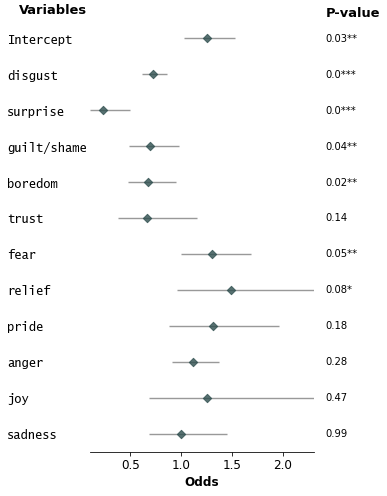

In [ ]:
params = model.params
conf = model.conf_int()
conf['Odds'] = model.params
conf.columns = ['5%', '95%', 'Effect']
conf = np.exp(conf)
conf["Variables"] = ["Intercept"] + [re_feats(x) for x in list(params.index)[1:]]
conf["P-value"] = model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Variables",
              # ylabel="Odds (95% Conf. Int.)",  # y-label title
              xlabel="Odds",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-1,-.5,0,.5, 1],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/cmv_emo_forestplot.svg", bbox_inches="tight", format="svg")

Results

## 1.3 Polynomial multilinear regression

The following model uses all masked emotion features as above, but includes pairwise interaction between the variables. 
<!-- The model explains 1.4% of the variance in argument quality, but none of the coefficients are significant. Especially interesting is the fact that in this polynomial model, the multilinear model's most informative feature of _negative sentiment_ is no longer significant (p=0.159). There are however some interaction effects that approach significancy, namely negative effects for the interactions _pride:trust_ (p=0.075) and _boredom:pride_ (p=0.079), and positive effects for _boredom:relief_ (p=0.076) and _anger:positive_ (p=0.079). -->

In [28]:
# cols = emotion_probs_masked_whole+["prob_storytelling_mixed_domain", "persuasiveness"]
data = cmv[emo_cols]

# Using forward selection function to calculate best features
inter_result = poly_forward_selection(data, 'persuasiveness')
inter_model = inter_result["model"]
inter_remaining = inter_result["remaining"]
inter_sign = inter_result["significance"]
inter_r2 = inter_result["r2"]
print(inter_model.model.formula)
print(inter_model.summary())
print(inter_remaining)
list(zip(inter_r2, inter_sign))

prob_guilt_shame_masked_agg:prob_trust_masked_agg
Optimization terminated successfully.
         Current function value: 0.691860
         Iterations 4
prob_joy_masked_agg
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4
prob_surprise_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691986
         Iterations 3
prob_guilt_shame_masked_agg:prob_boredom_masked_agg
Optimization terminated successfully.
         Current function value: 0.691967
         Iterations 3
prob_trust_masked_agg:prob_guilt_shame_masked_agg
Optimization terminated successfully.
         Current function value: 0.691860
         Iterations 4
prob_trust_masked_agg:prob_joy_masked_agg
Optimization terminated successfully.
         Current function value: 0.691987
         Iterations 3
prob_pride_masked_agg:prob_disgust_masked_agg
Optimization terminated successfully.
         Current function value: 0.691940
 

[(np.float64(0.0012046554010123334), 'x'),
 (np.float64(0.0019246226070724903), np.float64(0.0006887692731893065)),
 (np.float64(0.002598373043766311), np.float64(0.001025917645810731)),
 (np.float64(0.003054694482069853), np.float64(0.006886373200959316)),
 (np.float64(0.0033689986621192602), np.float64(0.024908937025198866)),
 (np.float64(0.0037074198052919893), np.float64(0.019951997922165583)),
 (np.float64(0.0041208803378440795), np.float64(0.010102824165997804)),
 (np.float64(0.0045173461903489365), np.float64(0.011772711535459559)),
 (np.float64(0.004729011302504915), np.float64(0.06568116992028838))]

In [29]:
inter_model.aic

np.float64(15954.118951554901)

Results

# 2. Storytelling


In [30]:
all_story = storytelling + storytelling_probs
story_results = {"mixed_domain": {"discreet":{}, "prob": {}}, "one_domain": {"discreet":{}, "prob": {}}}

for v in all_story:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    result = logit(formula, cmv).fit()
    story = v.split("_")
    if "prob" in v:
        if "one" in v:
            story_results["one_domain"]["prob"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["prob"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
    else: 
        if "one" in v:
            story_results["one_domain"]["discreet"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["discreet"] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
    print(result.summary())

story_res = {"r2":{}, "odds": {}, "p": {}}
for dom in story_results:
    for anno in story_results[dom]:
        for stat in story_results[dom][anno]:
            story_res[stat][dom+"/"+anno] = story_results[dom][anno][stat]
story_res = pd.DataFrame(story_res).sort_values(by="r2")
story_res

# params = results.params
# conf = results.conf_int()
# conf['Odds Ratio'] = params
# conf.columns = ['5%', '95%', 'Odds Ratio']
# print(np.exp(conf), "\n")

IV: storytelling_mixed_domain
Optimization terminated successfully.
         Current function value: 0.691859
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               0.0001861
Time:                        11:55:51   Log-Likelihood:                -8002.7
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                   0.08436
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0804      0.021 

,r2,odds,p
one_domain/discreet,0.000005,0.986139,0.779520
mixed_domain/discreet,0.000186,1.084097,0.084544
one_domain/prob,0.000338,1.215744,0.020012
mixed_domain/prob,0.000370,1.148255,0.015059


In contrast to the IBM dataset, the discreet storytelling annotation does not have a significant effect on argument strength, i.e., persuasiveness in CMV. The probability annotation however has a significant positive effect on persuasiveness, which suggests that IBM and CMV have a different relation between strength and story, with IBM favoring impersonal and CMV favoring personal arguments.

# 3. Hedging

The independent variables used in the following models are the absolute count and ratio of hedge words for the first, last and all sentences

In [31]:
hedging

['first_abs_hedge',
 'first_hedge',
 'final_abs_hedge',
 'final_hedge',
 'global_abs_hedge',
 'avg_hedge']

## 3.1 Bivariate linear regression

In [32]:
hedge_results = {"first": {"abs":{}, "avg": {}}, "final": {"abs":{}, "avg": {}}, "all": {"abs":{}, "avg": {}}}

for v in hedging:
    formula = f"persuasiveness ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    result = logit(formula, cmv).fit()
    h = v.split("_")
    if h[0] == "final":
        sent = "final"
    elif h[0] == "first":
        sent = "first"
    else:
        sent = "all"
    if "abs" in h:
        score = "abs"
    else:
        score = "avg"
    hedge_results[sent][score] = {"r2": result.prsquared, "odds": np.exp(result.params[v]), "p": result.pvalues[v]}
    print(result.summary())

h_res = {"r2":{}, "odds": {}, "p": {}}
for sent in hedge_results:
    for score in hedge_results[sent]:
        for stat in hedge_results[sent][score]:
            h_res[stat][sent+"/"+score] = hedge_results[sent][score][stat]
h_res = pd.DataFrame(h_res).sort_values(by="r2")
h_res

IV: first_abs_hedge
Optimization terminated successfully.
         Current function value: 0.691951
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11565
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               5.271e-05
Time:                        11:55:59   Log-Likelihood:                -8003.8
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                    0.3583
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0837      0.023      3.614      0.000       0.038       

,r2,odds,p
final/abs,2.797430e-07,0.998867,9.466460e-01
first/avg,2.068094e-05,1.234631,5.651272e-01
first/abs,5.271184e-05,1.017755,3.584767e-01
final/avg,1.156999e-04,0.579429,1.735090e-01
all/avg,3.504843e-04,0.124208,1.793071e-02
all/abs,1.056030e-02,1.030315,4.373940e-36


The informative hedging features include the first sentence's absolute number (R<sup>2</sup>=.004) and ratio (R<sup>2</sup>=.003) of hedge words, the averaged hedge ratio of all sentences (R<sup>2</sup>=.003), and the overall number of hedge words (R<sup>2</sup>=.001, \*\*). All coefficients are negative and (highly) significant, paired with a positive highly significant intercept. This is interesting insofar as most arguments in the cmv dataset repeat the stance given at argument generation in the first sentence, to then include the actual generated argument in the later sentences. As the absolute and averaged number of hedges in the final sentence do not explain any variance in the argument quality scores but have positive coefficients, this result might show a simple regression on the argument topics or stances, many of which include "should", overestimating argument quality through the intercept and mitigating this for topics that have overall less qualitative arguments.

## 3.2 Multilinear regression

In [ ]:
v = ['avg_hedge',
 'final_abs_hedge',
 'first_abs_hedge',]
x = cmv.loc[:, v]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=7)
formula = "persuasiveness ~ " + " + ".join(v)
hedge_train = pd.concat((x_train,y_train), axis=1)
hedge_test = pd.concat((x_test,y_test), axis=1)
# Old code, sm.logit is possibly deprecated, so changed to match all other model fits
# x_train = sm.add_constant(x_train)
# x_test = sm.add_constant(x_test)
# model = sm.logit(y_train, x_train)
# results = model.fit()
results = logit(formula, hedge_train).fit()
print("==============================================================================", "\n", "IV:  hedging scores", sep="")
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 4
IV:  hedging scores
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                 8675
Model:                          Logit   Df Residuals:                     8671
Method:                           MLE   Df Model:                            3
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:               0.0003556
Time:                        13:25:30   Log-Likelihood:                -6002.5
converged:                       True   LL-Null:                       -6004.6
Covariance Type:            nonrobust   LLR p-value:                    0.2337
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1133      0.042      2.679      0.007       0.030       

Unlike the bivariate experiments, we can see here that the unexpected behavior of the first sentence's effect is gone (p=.69 and p=.73) and instead the two features measuring hedging in the final sentence explain most of the variance (adj. R<sup>2</sup>=.008) with the absolute number having a highly significant positive effect and the ratio of hedge words a significant negative effect. The negative effect of the absolute number of overall hedge words is also significant (p=.034, \*)

### 3.2.1 Hedging Multicolinearity

In [42]:
h = cmv[['final_abs_hedge', 'first_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge', 'final_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['first_abs_hedge', 'first_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['avg_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge','first_abs_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = cmv[['final_abs_hedge','first_abs_hedge','avg_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

# z = cmv.loc[:, "final_hedge"]
# x = cmv.loc[:, "final_abs_hedge"]
# x_train, x_test, y_train, y_test = train_test_split(x, z, test_size=0.25, random_state=7)
# x_train = sm.add_constant(x_train)
# x_test = sm.add_constant(x_test)

# model = sm.logit(y_train, x_train)
# results = model.fit()
# print("==============================================================================", "\n", "IV:  hedging scores", sep="")
# print(results.summary())

           feature       VIF
0  final_abs_hedge  1.237992
1  first_abs_hedge  1.237992 

           feature       VIF
0  final_abs_hedge  3.387288
1      final_hedge  3.387288 

           feature      VIF
0  first_abs_hedge  3.20613
1      first_hedge  3.20613 

            feature       VIF
0         avg_hedge  2.039525
1  global_abs_hedge  2.039525 

            feature       VIF
0   final_abs_hedge  1.510570
1   first_abs_hedge  1.424105
2  global_abs_hedge  1.656199 

           feature       VIF
0  final_abs_hedge  1.893052
1  first_abs_hedge  1.766734
2        avg_hedge  2.699877 



While there is no multicolinearity between the first and final sentence's hedge features (VIF =1.402), the absolute and averaged features of the same span (first, final, all sentences) are highly correlated as they are calculated from the same base hedge counts and the global hedge counts and averages are similarly correlated with the features of the individual sentences. 

## 3.3 Polynomial multilinear regression

In [44]:
formula = ""
for h in ["final_abs_hedge", "first_abs_hedge", "avg_hedge"]:
    formula += f" + {h}"
formula = "persuasiveness ~ ("+ formula[3:]+")**2"

interact = logit(formula, cmv).fit()
print("==============================================================================", "\n", "IV: hedging scores", sep="")
print(interact.summary())

Optimization terminated successfully.
         Current function value: 0.690792
         Iterations 5
IV: hedging scores
                           Logit Regression Results                           
Dep. Variable:         persuasiveness   No. Observations:                11567
Model:                          Logit   Df Residuals:                    11560
Method:                           MLE   Df Model:                            6
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                0.001728
Time:                        13:27:51   Log-Likelihood:                -7990.4
converged:                       True   LL-Null:                       -8004.2
Covariance Type:            nonrobust   LLR p-value:                 0.0001089
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.0777     

The hedging analysis with interaction explains most variance of all hedging models, but changes which individual features are most informative. The positive effect of the number of hedges in the final sentence is lowered (p=.022 \*), while the negative effect of the first sentence reemerges (p=.00 \*\*\*). The interaction between number of hedges in the final sentence and overall ratio of hedges is also significant (p=.003 \*\*) and the only insignificant features are the overall average number of hedges (p=.056) and its interaction with the number of hedges in the first sentence (p=.129).

# Plotting effects and interactions

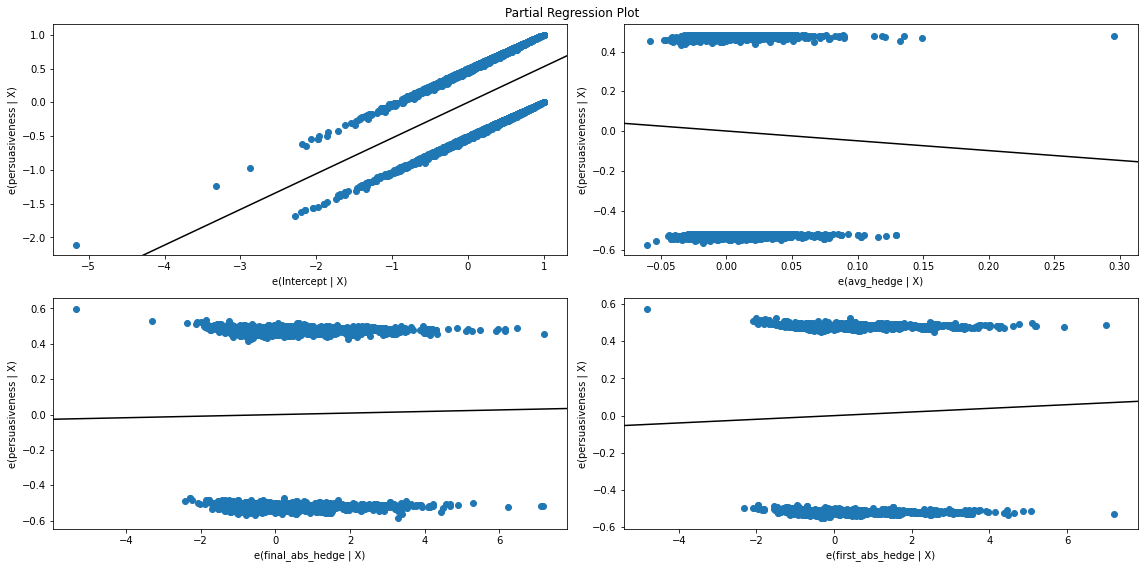

In [46]:
fig = sm.graphics.plot_partregress_grid(results)
plt.rc("figure", figsize=(16, 8))
# plt.rc("font", size=14)
# fig.tight_layout(pad=1.0)

## Validity of Results

### No Multicolinearity

In [47]:
vif = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=x_train.columns).T

,avg_hedge,final_abs_hedge,first_abs_hedge
vif,2.718501,1.885769,1.773622


### Normality of Residuals

<Axes: ylabel='Density'>

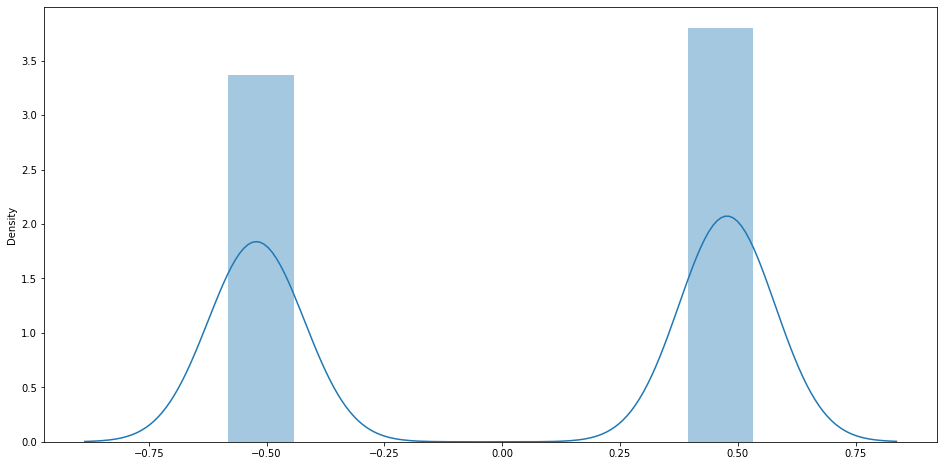

In [48]:
y_pred = results.predict(x_test)
residual = y_test - y_pred
sns.distplot(residual)

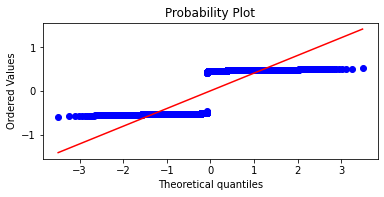

In [49]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

### Homoscedasticity

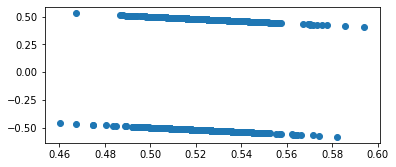

In [50]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

### Autocorrelation of residuals  


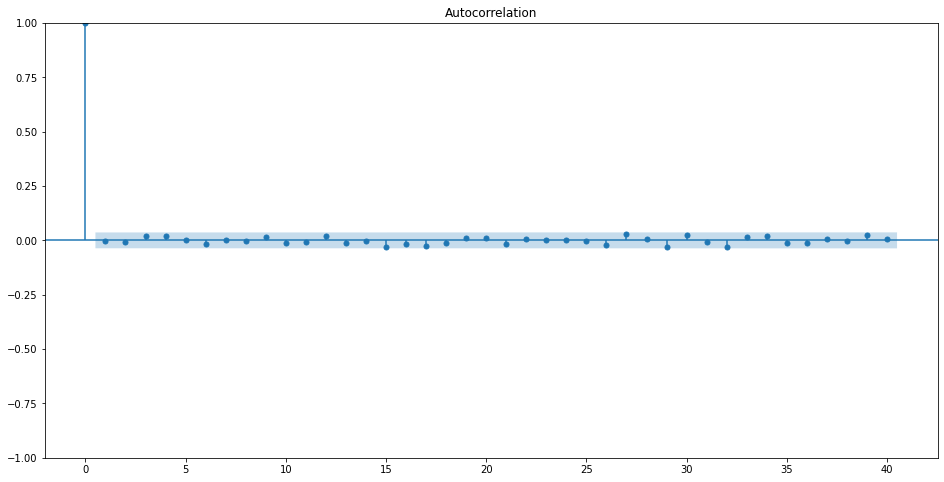

In [51]:
acf = smt.graphics.plot_acf(residual, lags=40, alpha=0.05)
acf.show()

In [ ]:
# x = cmv.loc[:, ["positive_unmasked", "negative_unmasked", "storytelling_mixed_domain", "global_abs_hedge", "final_hedge"]]
# formula = "rank ~ C(negative_unmasked) * C(storytelling_mixed_domain) + C(negative_unmasked) * C(positive_unmasked) + global_abs_hedge + final_hedge"

# 4. Multilinear Regression with all Features

In [15]:
features = ["persuasiveness", "prob_storytelling_mixed_domain", "global_abs_hedge"] + emotion_probs_masked
# features = ["persuasiveness", "prob_storytelling_mixed_domain", "final_abs_hedge"] + emotion_probs_masked
# features = ["persuasiveness", "storytelling_one_domain", "final_abs_hedge"] + emotion_probs_masked

data = cmv[features]
# Using forward selection function to calculate best features
full_multi_result = forward_selection(data, 'persuasiveness')
full_multi_model = full_multi_result["model"]
full_multi_remaining = full_multi_result["remaining"]
full_multi_sign = full_multi_result["significance"]
full_multi_r2 = full_multi_result["r2"]
print(full_multi_model.model.formula)
print(full_multi_model.summary())
print(full_multi_remaining)
# list(zip(full_multi_r2, full_multi_sign))

names = map(re_feats,list(full_multi_model.params.index)[1:len(full_multi_r2)+1])
r_list = pd.DataFrame(list(zip(names, full_multi_r2, full_multi_sign)), columns=("Emotion", "\\textbf{pseudo-\\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

Optimization terminated successfully.
         Current function value: 0.691808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691656
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691674
  

Intercept                         5.294445e-02
global_abs_hedge                  3.377439e-33
prob_relief_masked_agg            1.854161e-02
prob_pride_masked_agg             7.406287e-02
prob_fear_masked_agg              7.809937e-02
prob_disgust_masked_agg           2.137705e-01
prob_guilt_shame_masked_agg       3.125682e-01
prob_boredom_masked_agg           4.767042e-01
prob_storytelling_mixed_domain    6.475895e-01
prob_sadness_masked_agg           7.715667e-01
prob_joy_masked_agg               8.604788e-01
prob_anger_masked_agg             8.884240e-01
prob_trust_masked_agg             9.373870e-01
Name: P-value, dtype: float64


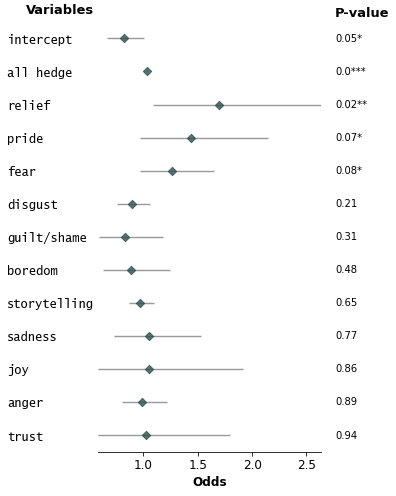

In [16]:
params = full_multi_model.params
conf = full_multi_model.conf_int()
conf['Odds'] = full_multi_model.params
conf.columns = ['5%', '95%', 'Effect']
conf = np.exp(conf)
conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(params.index)[1:]]
conf["P-value"] = full_multi_model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Variables",
              # ylabel="Odds (95% Conf. Int.)",  # y-label title
              xlabel="Odds",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-1,-.5,0,.5, 1],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/cmv_multilinear_forestplot.svg", bbox_inches="tight", format="svg")
print(conf["P-value"])

### Testing for multicolinearity

In [54]:
v = cmv[list(params.index)[1:]]#-1]]
vif_data = pd.DataFrame() 
vif_data["feature"] = list(map(re_feats, v.columns))
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
# vif_data.sort_values("VIF",inplace=True)
print("Full variable set:")
print(vif_data.to_latex(float_format="%.4f",index=False))
vif_data

Full variable set:
\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
disgust & 3.6382 \\
surprise & 1.7695 \\
guilt/shame & 2.5316 \\
boredom & 1.3788 \\
storytelling & 1.4541 \\
fear & 1.6016 \\
trust & 1.3421 \\
relief & 1.4560 \\
pride & 2.7428 \\
anger & 4.8713 \\
joy & 2.3998 \\
final hedge & 1.6541 \\
sadness & 2.1536 \\
\bottomrule
\end{tabular}



,feature,VIF
0,disgust,3.638174
1,surprise,1.769549
2,guilt/shame,2.531632
3,boredom,1.378848
4,storytelling,1.454081
5,fear,1.601612
6,trust,1.342082
7,relief,1.456048
8,pride,2.742756
9,anger,4.871331


## Full Model with Interaction

In [17]:
# Using forward selection function to calculate best features
full_result = poly_forward_selection(data, 'persuasiveness')
full_model = full_result["model"]
full_remaining = full_result["remaining"]
full_sign = full_result["significance"]
full_r2 = full_result["r2"]
print(full_model.model.formula)
print(full_model.summary())
print(full_remaining)
list(zip(full_r2, full_sign))

names = map(re_feats,list(full_model.params.index)[1:len(full_r2)+1])
r_list = pd.DataFrame(list(zip(names, full_r2, full_sign)), columns=("Emotion", "\\textbf{pseudo-\\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

prob_fear_masked_agg:prob_disgust_masked_agg
Optimization terminated successfully.
         Current function value: 0.691966
         Iterations 3
prob_sadness_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691672
         Iterations 4
prob_joy_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 4
prob_trust_masked_agg:prob_fear_masked_agg
Optimization terminated successfully.
         Current function value: 0.691916
         Iterations 4
prob_relief_masked_agg:prob_pride_masked_agg
Optimization terminated successfully.
         Current function value: 0.691705
         Iterations 4
prob_relief_masked_agg:prob_guilt_shame_masked_agg
Optimization terminated successfully.
         Current function value: 0.691886
         Iterations 4
prob_storytelling_mixed_domain:prob_disgust_masked_agg
Optimization terminated successfully.
         Current functi

In [56]:
print(full_model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                               &  persuasiveness  & \textbf{  No. Observations:  } &    11567    \\
\textbf{Model:}                                                       &      Logit       & \textbf{  Df Residuals:      } &    11559    \\
\textbf{Method:}                                                      &       MLE        & \textbf{  Df Model:          } &        7    \\
\textbf{Date:}                                                        & Wed, 19 Feb 2025 & \textbf{  Pseudo R-squ.:     } &  0.004219   \\
\textbf{Time:}                                                        &     13:31:48     & \textbf{  Log-Likelihood:    } &   -7970.5   \\
\textbf{converged:}                                                   &       True       & \textbf{  LL-Null:           } &   -8004.2   \\
\textbf{Covariance Type:}                                             &    nonrobust     & \textbf{  LLR p-value:       

# Plotting regression results

\begin{tabular}{rrrlr}
\toprule
5% & 95% & Effect & Variables & P-value \\
\midrule
1.0576 & 1.2322 & 1.1416 & intercept & 0.0007 \\
0.1952 & 0.5677 & 0.3329 & disgust : guilt/shame & 0.0001 \\
9.8180 & 4170.1422 & 202.3421 & fear : pride & 0.0006 \\
0.1228 & 0.5177 & 0.2522 & surprise & 0.0002 \\
1.5943 & 14.3770 & 4.7876 & anger : relief & 0.0052 \\
1.7109 & 5.6284 & 3.1031 & pride : storytelling & 0.0002 \\
0.2380 & 0.7706 & 0.4282 & boredom : storytelling & 0.0047 \\
0.0033 & 0.7454 & 0.0492 & pride : trust & 0.0299 \\
\bottomrule
\end{tabular}



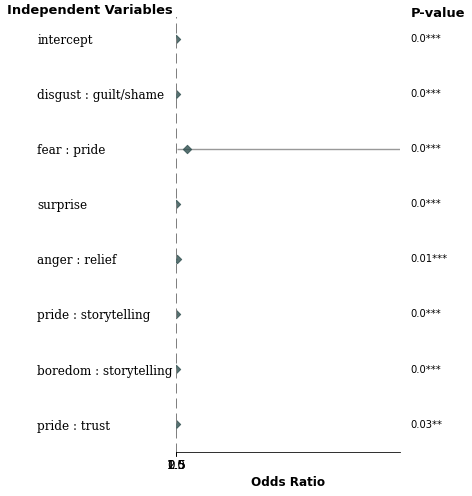

In [ ]:
full_params = full_model.params
full_conf = full_model.conf_int()
full_conf['Odds'] = full_model.params
full_conf.columns = ['5%', '95%', 'Effect']
full_conf = np.exp(full_conf)
# full_conf['5%'][2] = 1
# full_conf['5%'][4] = 1
# full_conf['5%'][5] = 1
# full_conf['Effect'][2] = 1
# full_conf['Effect'][4] = 1
# full_conf['Effect'][5] = 1
# full_conf['95%'][2] = 1
# full_conf['95%'][4] = 1
# full_conf['95%'][5] = 1
full_conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(full_params.index)[1:]]
full_conf["P-value"] = full_model.pvalues

fp.forestplot(full_conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Independent Variables",
              # ylabel="Odds (95% Conf. Int.)",  # y-label title
              xlabel="Odds Ratio",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              xticks=[.5, 1,1.5,2.5],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (1, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )
plt.savefig("img/cmv_poly_forestplot.svg", bbox_inches="tight", format="svg")

full_conf.set_index("Variables")
print(full_conf.to_latex(float_format="%.4f",index=False))

In [ ]:
def get_interaction_effect(interaction: str):
    inter_model = logit("persuasiveness ~"+interaction, cmv).fit()
    iv_1 = pd.Series(cmv[interaction.split(":")[0]], name = re_feats(cmv[interaction.split(":")[0]].name))
    tmp = np.log(cmv[interaction.split(":")[1]]) 
    iv_2 = []
    for instance in tmp:
        if instance <= tmp.mean()-tmp.std():
            iv_2.append("- 1 SD")
        elif instance <= tmp.mean()+tmp.std():
            iv_2.append("MEAN")
        elif instance <= tmp.mean()+2*tmp.std():
            iv_2.append("+ 1 SD")
        else:
            iv_2.append("+ 2 SD")
    hue_order = ["+ 2 SD", "+ 1 SD", "MEAN", "- 1 SD"]
    iv_2 = pd.Series(iv_2,name=re_feats(tmp.name))
    dv = pd.Series(inter_model.fittedvalues, name="persuasiveness")
    df = pd.concat((iv_1, iv_2, dv), axis=1)
    sns.relplot(
        data=df, kind="line", 
        x=iv_1.name, y="persuasiveness", 
        hue=iv_2.name, style=iv_2.name,
        hue_order=hue_order, 
        palette="mako" # mako plasma crest inferno
    )

def get_individual_effect(iv: str, num: (int, int)):
    if num[1] < 6:
        color = sns.color_palette("mako").as_hex()[num[0]+1]
    elif num[1] > 6:
        color = sns.color_palette("mako", n_colors=num[1]).as_hex()[num[0]]
    else:
        color = sns.color_palette("mako").as_hex()[num[0]]
    output = sns.regplot(data=cmv, x=iv, y="persuasiveness", scatter=False, color=color, logistic=True)
    output.set(xlabel=re_feats(cmv[iv].name))
    plt.savefig("img/cmv_"+iv+".svg", format="svg")
    plt.show()
    # model = logit("persuasiveness ~"+iv, cmv).fit()
    # iv = pd.Series(cmv[iv], name=re_feats(iv))
    # dv = pd.Series(model.fittedvalues, name="persuasiveness")
    # df = pd.concat((iv,dv), axis=1)
    # sns.relplot(
    #     data=df, x=iv.name, y=dv.name, palette="mako"
    # )

## Interaction results

Optimization terminated successfully.
         Current function value: 0.691154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691949
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691957
         Iterations 4


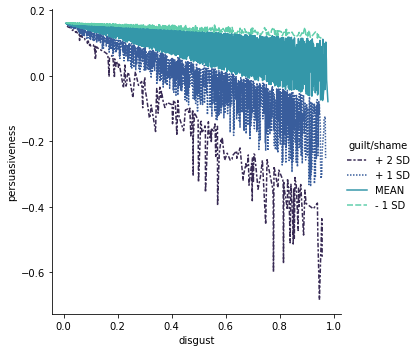

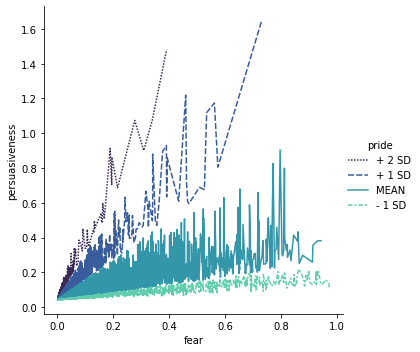

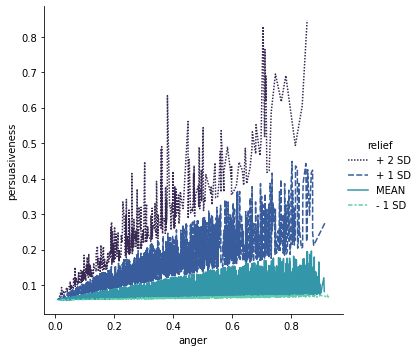

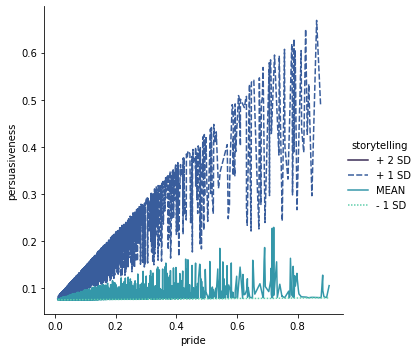

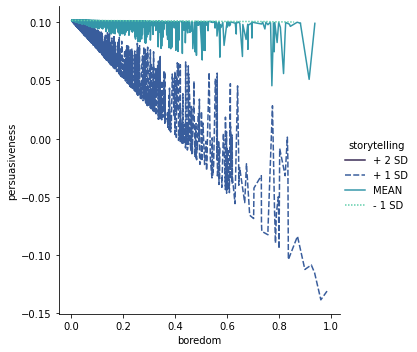

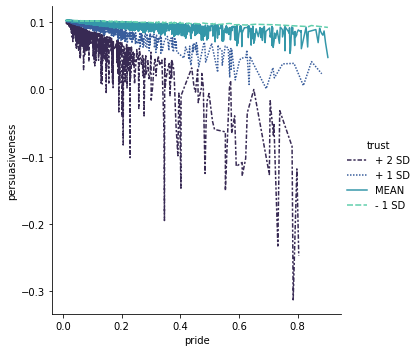

In [26]:
inter_ivs = []
for iv in list(full_params.index)[1:]:
    if ":" in iv:
        inter_ivs.append(iv)
        get_interaction_effect(iv)

## Individual regression plots

### Emotions

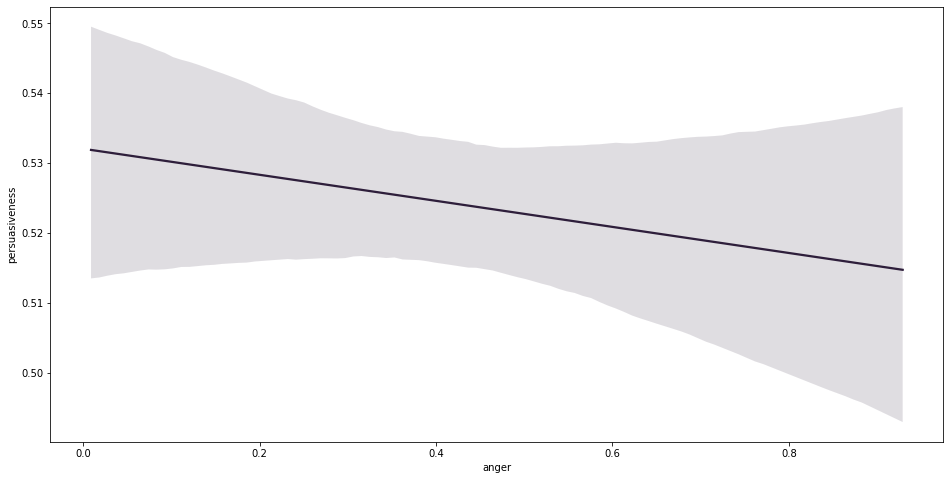

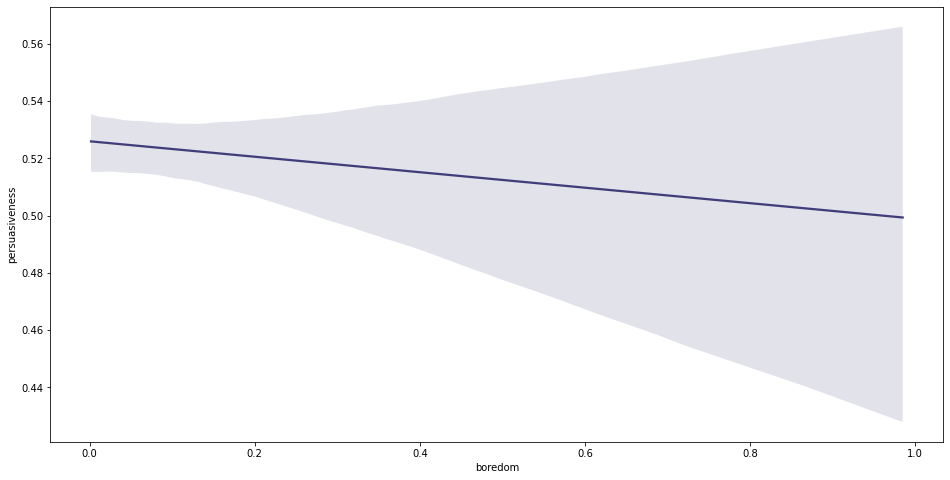

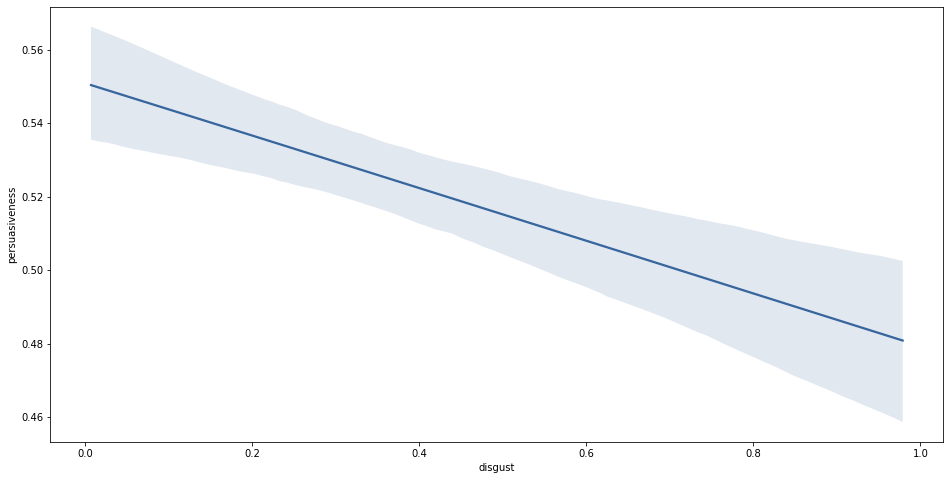

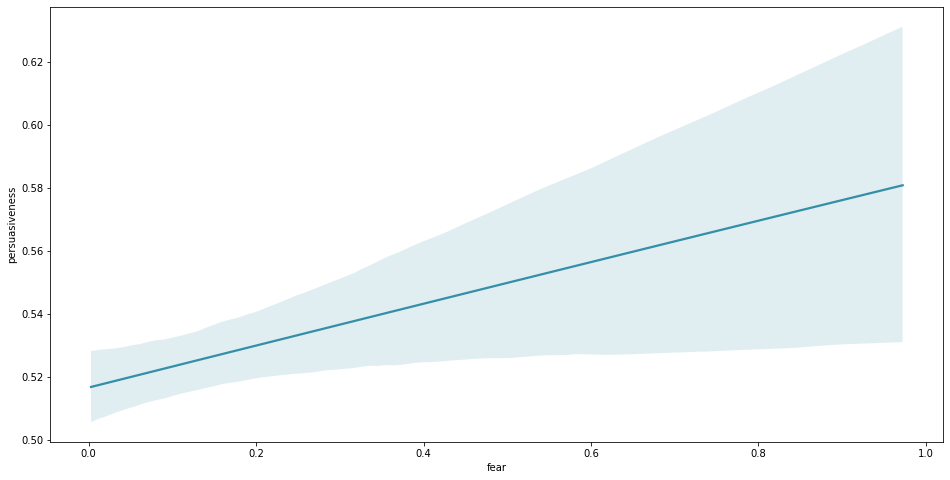

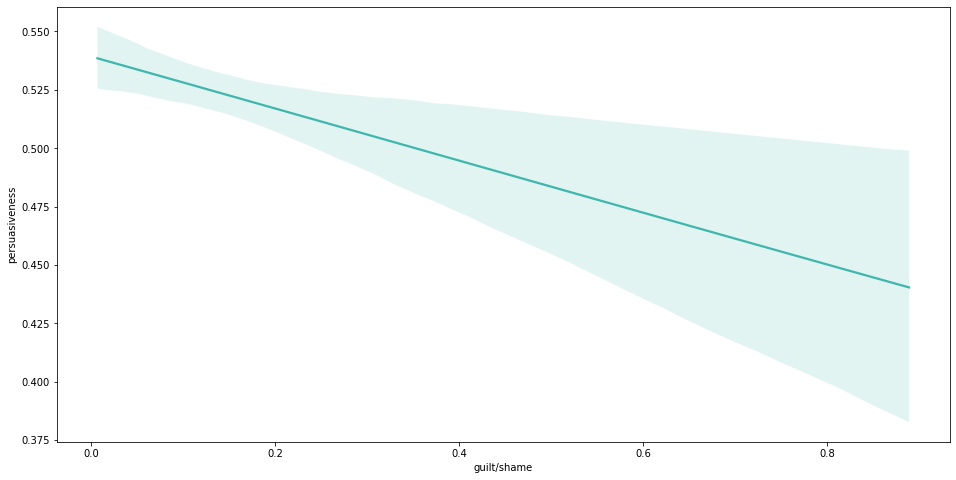

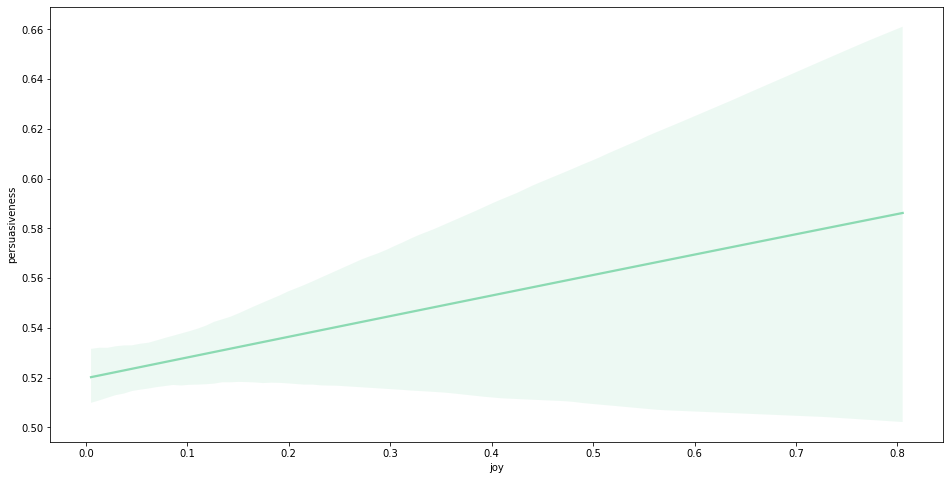

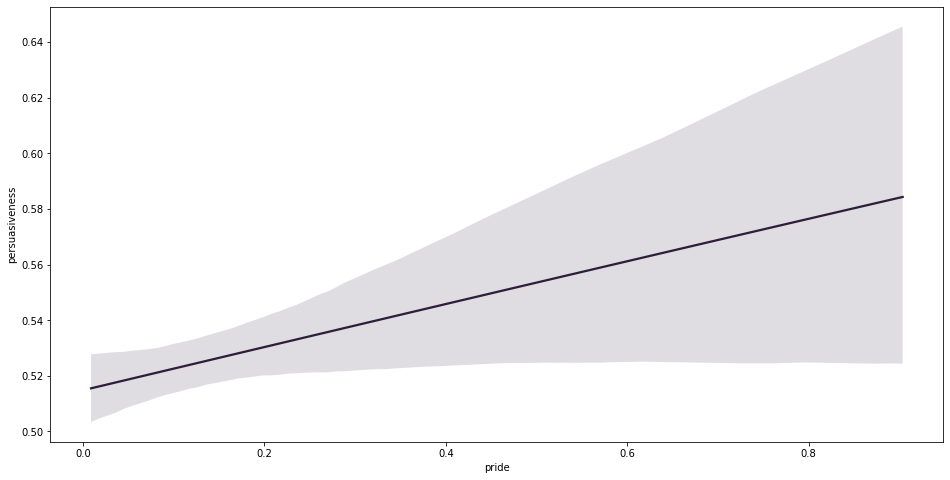

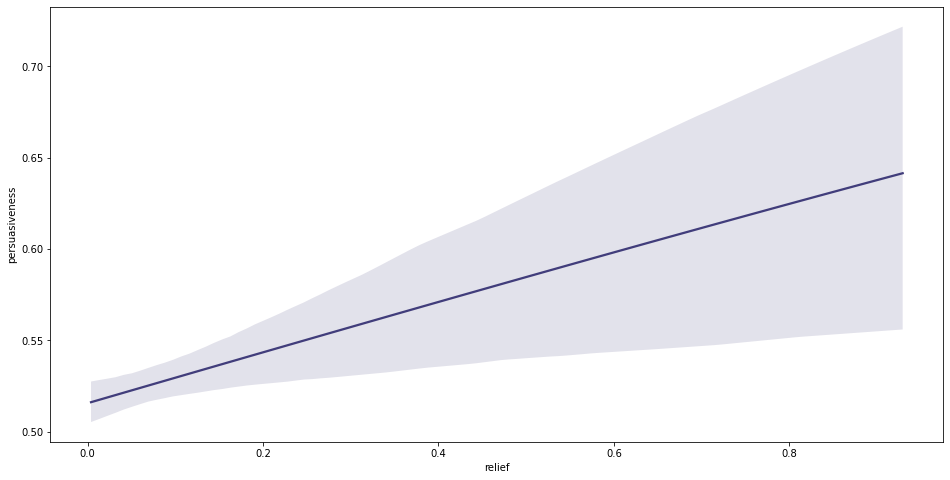

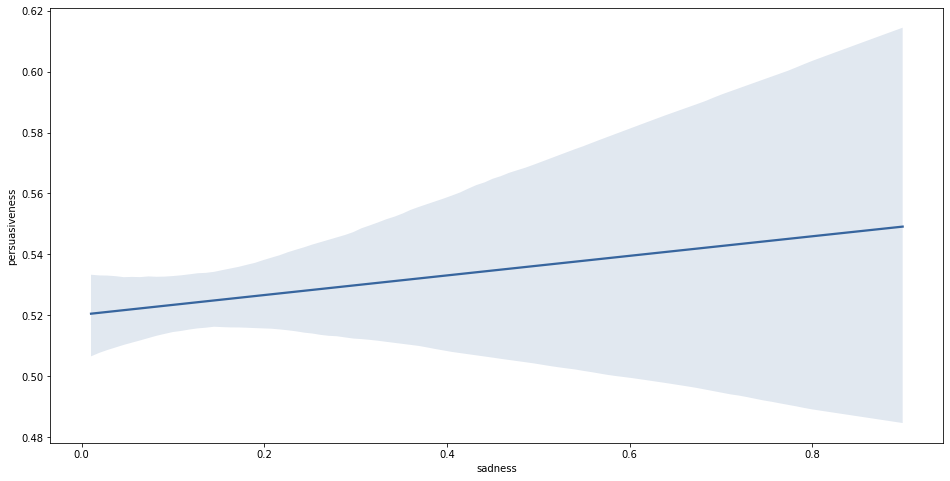

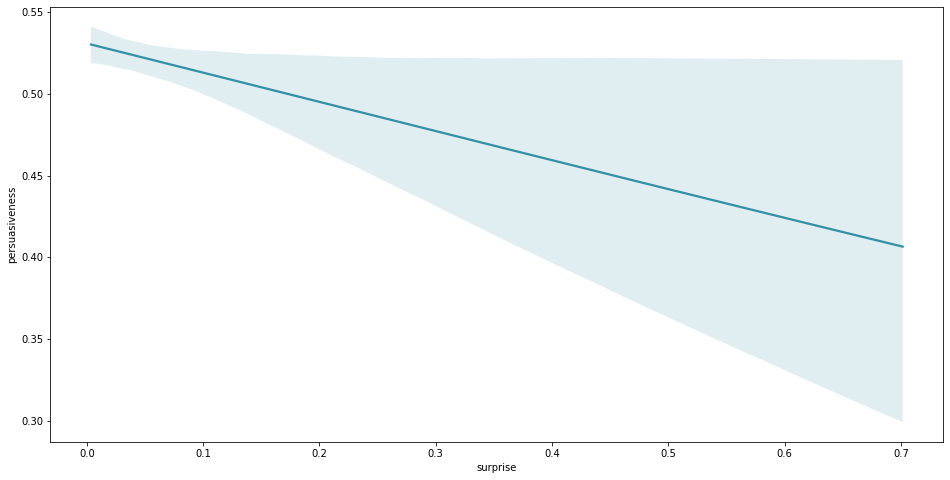

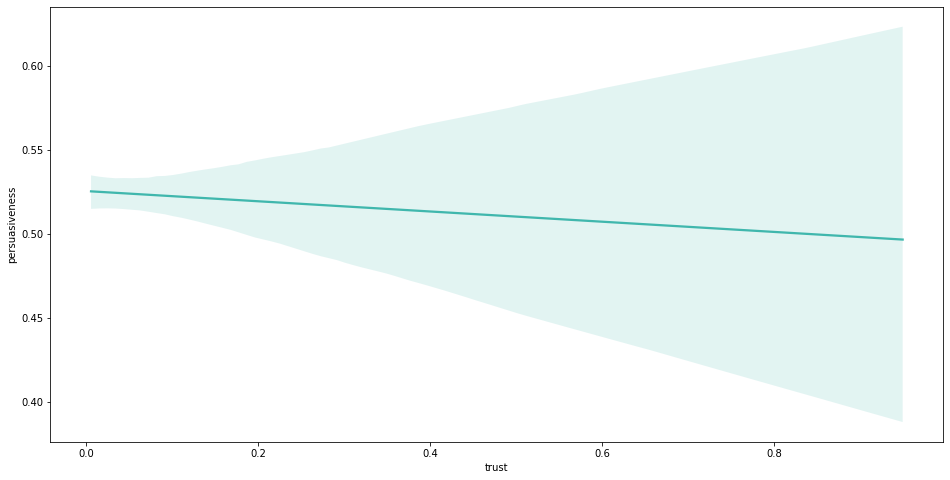

In [62]:
for i, iv in enumerate(emotion_probs_masked):
    get_individual_effect(iv, (i%6,6))

### Hedging

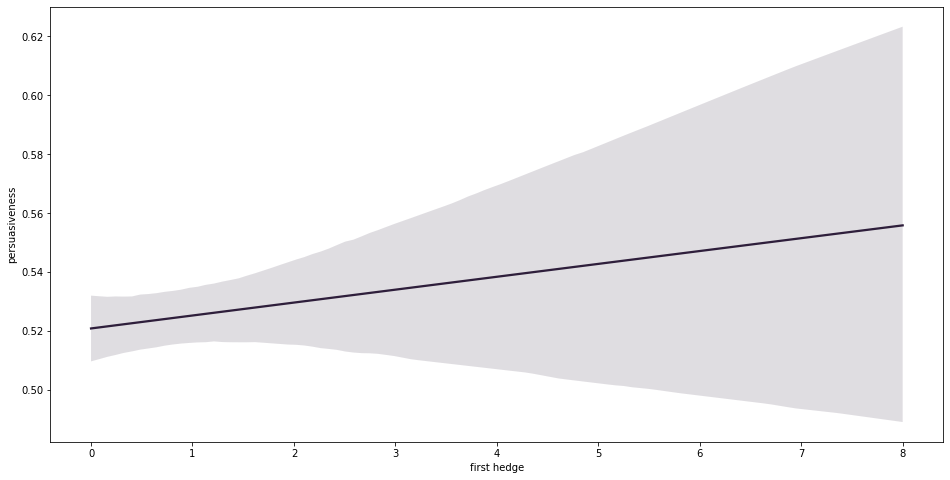

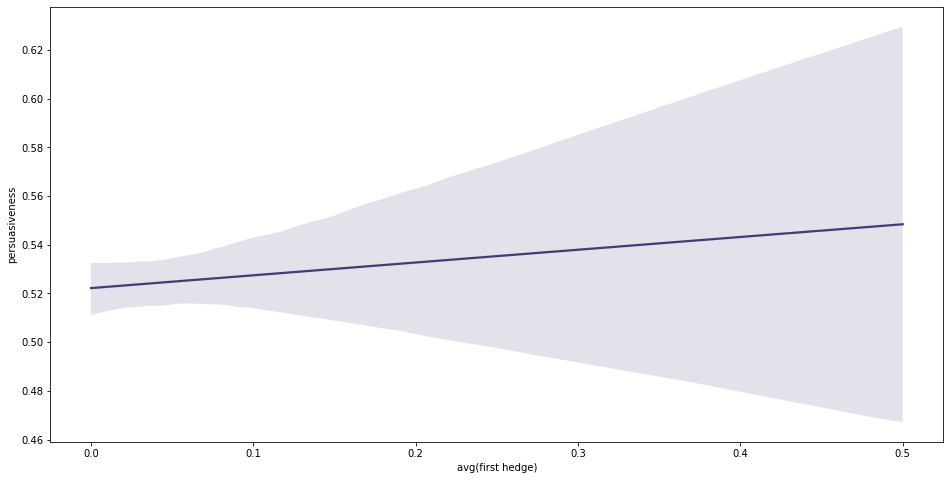

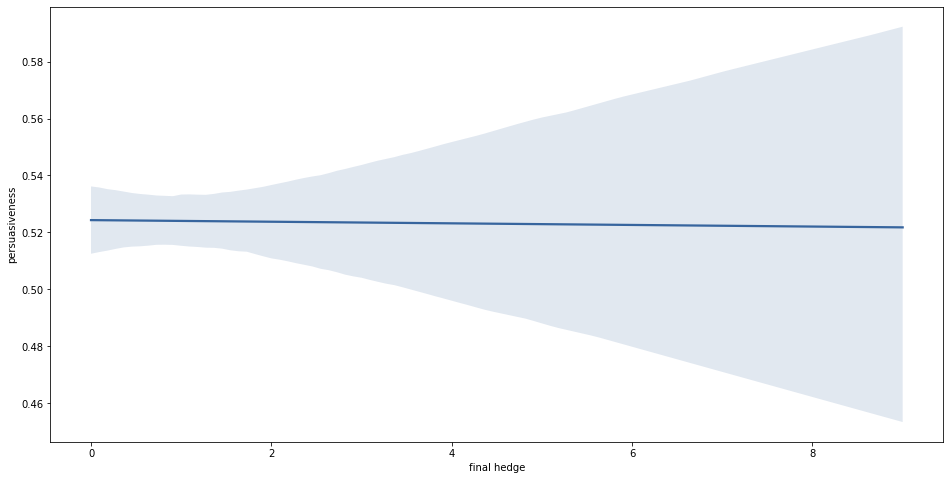

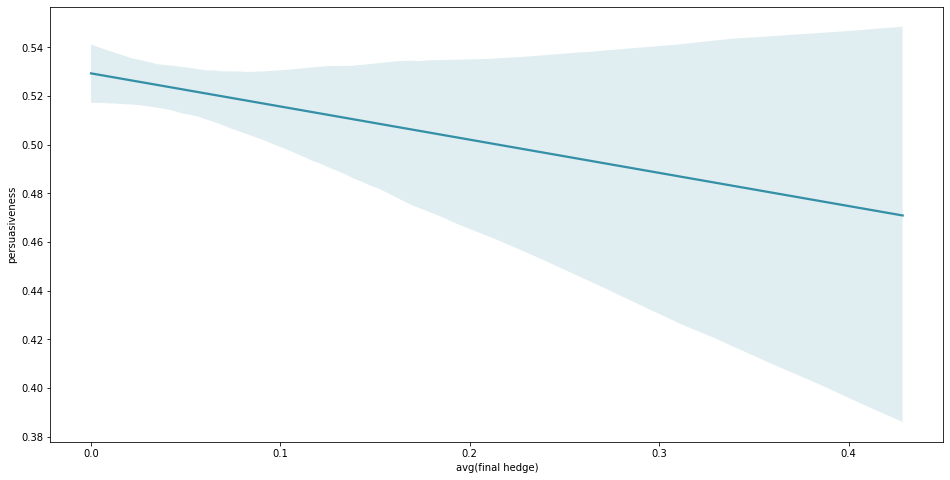

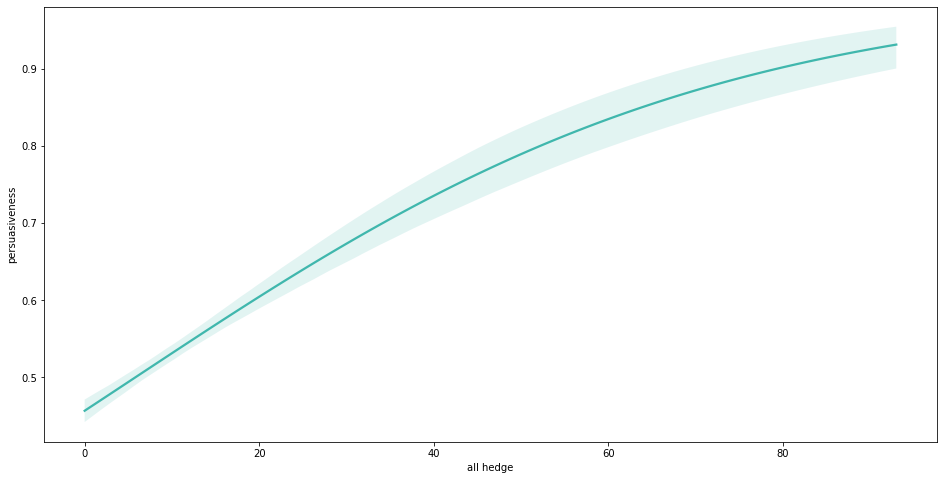

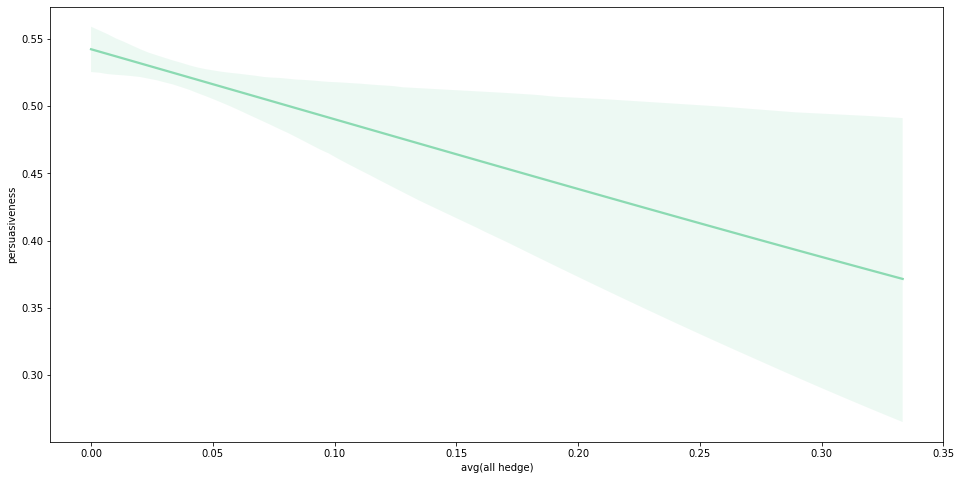

In [63]:
for i, iv in enumerate(hedging):
    get_individual_effect(iv, (i,6))

### Storytelling

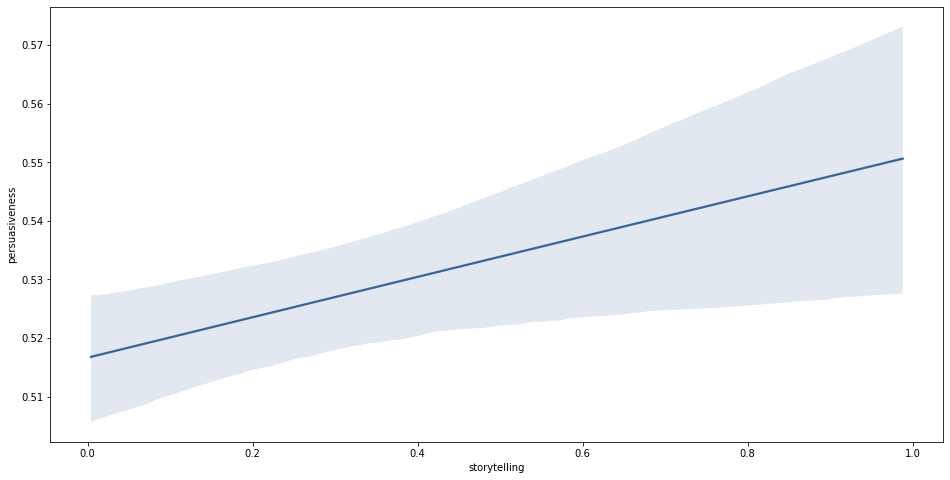

In [64]:
get_individual_effect("prob_storytelling_mixed_domain", (2,6))

# Testing and stuff

In [65]:
def get_log_sds(iv: str):
    log = np.log(cmv[iv])
    mean = log.mean()
    std = log.std()
    print(f"-1SD: {np.exp(mean-std):.4f}, MEAN: {np.exp(mean):.4f}, \n+1SD: {np.exp(mean+std):.4f}, +2STD: {np.exp(mean+2*std):.4f}")
def get_sds(iv: str):
    mean = cmv[iv].mean()
    std = cmv[iv].std()
    print(f"-1SD: {mean-std:.4f}, MEAN: {mean:.4f}, \n+1SD: {mean+std:.4f}, +2STD: {mean+2*std:.4f}")

get_sds("prob_surprise_masked_agg")

-1SD: -0.0151, MEAN: 0.0380, 
+1SD: 0.0911, +2STD: 0.1442


## Effect sizes

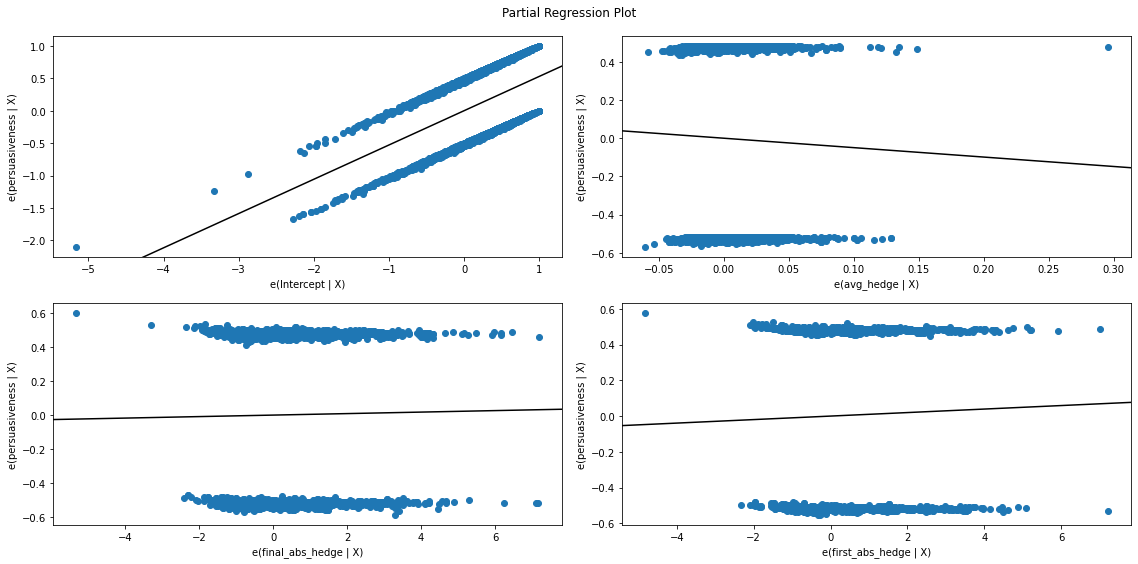

In [66]:
fig = sm.graphics.plot_partregress_grid(results)
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
fig.tight_layout(pad=1.0)

## Interactions

In [32]:
features = ["storytelling_mixed_domain", "final_abs_hedge", "joy_unmasked", "trust_masked", "disgust_unmasked", "relief_masked", "guilt_shame_unmasked", "pride_masked", "positive_masked", "negative_unmasked"]
# Unused emotions (no effect in linear regression): sadness, boredom, fear, anger, surprise, overall emotionality

formula = ""
for f in features:
    formula += f" + {f}"
formula = "rank ~"+ "(" + formula[2:] + ")**2"
# formula


results = ols(formula, cmv).fit()
print("==============================================================================", "\n", "IV:  all features", sep="")
print(results.summary())

IV:  all features
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.322
Date:                Sat, 14 Oct 2023   Prob (F-statistic):           5.02e-10
Time:                        11:08:53   Log-Likelihood:                 889.27
No. Observations:                5298   AIC:                            -1711.
Df Residuals:                    5264   BIC:                            -1487.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Testing for Validity of Results

### No Multicolinearity

In [35]:
# Generally, a VIF above 5 indicates a high multicollinearity. 

v = cmv[hedging]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Hedging variables:\n", vif_data, "\n")

v = cmv[neg_masked+pos_masked]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Masked emotion variables:\n", vif_data, "\n")

v = cmv[neg_masked+["negative_masked", "emotionality_masked"]]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Masked negative emotion variables:\n", vif_data, "\n")

v = cmv[pos_masked+["positive_masked", "emotionality_masked"]]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Masked positive emotion variables:\n", vif_data, "\n")

v = cmv[neg_unmasked+pos_unmasked+["positive_unmasked", "negative_unmasked", "emotionality_unmasked"]]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Unmasked emotion variables:\n", vif_data, "\n")

v = cmv[story]
vif_data = pd.DataFrame() 
vif_data["feature"] = v.columns 
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
print("Storytelling variables:\n", vif_data, "\n")


Hedging variables:
             feature        VIF
0         avg_hedge  41.739153
1   final_abs_hedge   9.799787
2       final_hedge   6.648713
3   first_abs_hedge  29.626842
4       first_hedge  49.552815
5  global_abs_hedge  19.037433 

Masked emotion variables:
                feature       VIF
0         anger_masked  1.724917
1       boredom_masked  1.014522
2       disgust_masked  1.706029
3          fear_masked  1.057261
4   guilt_shame_masked  1.042330
5       sadness_masked  1.049233
6           joy_masked  1.006823
7         pride_masked  1.008400
8        relief_masked  1.002343
9      surprise_masked       NaN
10        trust_masked  1.001067 

Masked negative emotion variables:
                feature        VIF
0         anger_masked   7.796626
1       boredom_masked   1.529944
2       disgust_masked  18.043783
3          fear_masked   2.473672
4   guilt_shame_masked   1.377448
5       sadness_masked   1.639671
6      negative_masked  12.589161
7  emotionality_masked  33.1

C:\Users\HP Envy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\HP Envy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\HP Envy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Unmasked emotion variables:
                   feature        VIF
0          anger_unmasked        inf
1        boredom_unmasked        inf
2        disgust_unmasked        inf
3           fear_unmasked        inf
4    guilt_shame_unmasked        inf
5        sadness_unmasked        inf
6            joy_unmasked        inf
7          pride_unmasked        inf
8         relief_unmasked        inf
9       surprise_unmasked        NaN
10         trust_unmasked        inf
11      positive_unmasked  86.804480
12      negative_unmasked  16.403902
13  emotionality_unmasked        inf 

Storytelling variables:
                      feature       VIF
0    storytelling_one_domain  1.866546
1  storytelling_mixed_domain  1.866546 



C:\Users\HP Envy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


### Normality of Residuals

<ipython-input-22-a8d85ebbc716>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: ylabel='Density'>

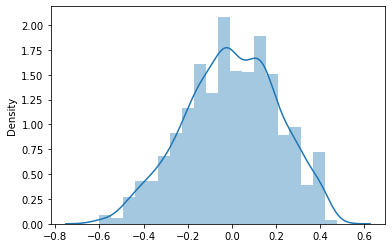

In [22]:
y_pred = results.predict(x_test)
residual = y_test - y_pred
sns.distplot(residual)

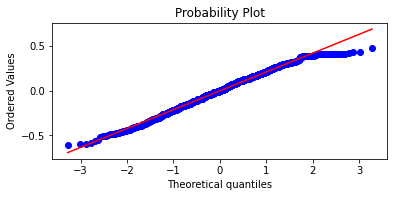

In [23]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

### Homoscedasticity

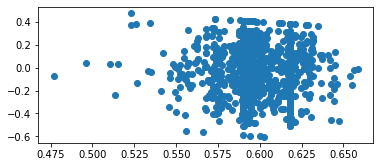

In [24]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

### Autocorrelation of residuals

<ipython-input-25-befeee66bdb4>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


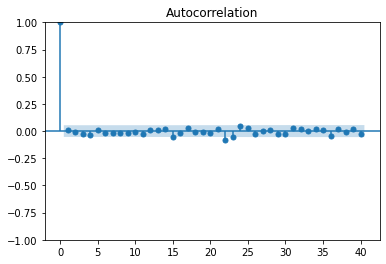

In [25]:
acf = smt.graphics.plot_acf(residual, lags=40, alpha=0.05)
acf.show()